#  Прогнозирование качества вин (Wine Quality Prediction)

## Описание задачи

Цель проекта — построить модель, способную предсказывать **качество вина** по его физико-химическим характеристикам.  
Для этого используется открытый датасет **Wine Quality Data Set** из репозитория [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/186/wine+quality).

Каждая строка представляет собой образец вина с 11 признаками, полученными в результате лабораторных тестов (например, кислотность, уровень сахара, pH, содержание спирта и др.), и целевой переменной — **оценкой качества** (от 0 до 10), выставленной профессиональными дегустаторами.

Доступны два поднабора:
- 🔴 Красное вино (`winequality-red.csv`)
- ⚪ Белое вино (`winequality-white.csv`)

---

## Этапы работы:

1. **Загрузка и изучение данных**
2. **Исследовательский анализ (EDA)** — визуализация распределений, корреляций, выбросов
3. **Предобработка данных** — масштабирование, очистка, разбиение
4. **Построение базовых моделей машинного обучения**  
   - Linear Regression  
   - Random Forest Regressor  
   *(в рамках задачи регрессии для начального сравнения с нейросетевым подходом)*
5. **Разработка нейросетевой модели (Feedforward Neural Network)**
6. **Оценка качества моделей** — MAE, R², визуализация `y_true vs y_pred`
7. **Выводы и направления для улучшения**

---

## Целевая переменная: `quality`  
Тип задачи: **регрессия** (предсказание непрерывной оценки)


### Импорты и загрузка данных:

In [3]:
# Библиотеки:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, f1_score, classification_report, confusion_matrix

from xgboost import XGBRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


# Настройки графиков
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Загрузка датасетов
red_df = pd.read_csv("winequality-red.csv", sep=";")
white_df = pd.read_csv("winequality-white.csv", sep=";")

# Проверка размеров
print(f"🔴 Красное вино: {red_df.shape} строк")
print(f"⚪ Белое вино: {white_df.shape} строк")


🔴 Красное вино: (1599, 12) строк
⚪ Белое вино: (4898, 12) строк


### Исследовательский анализ (EDA) 

In [5]:
#Первичный обзор:

# Первые строки
display(red_df.head())
display(white_df.head())

# Информация о типах данных
print("🔴 Красное:")
red_df.info()
print("\n⚪ Белое:")
white_df.info()

# Статистика
display(red_df.describe())
display(white_df.describe())


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


🔴 Красное:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

⚪ Белое:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


### Первичный анализ данных

Изучены два отдельных датасета:
- `winequality-red.csv` — содержит 1599 образцов красного вина
- `winequality-white.csv` — содержит 4898 образцов белого вина

Признаки совпадают, но статистики показывают **существенные различия** между типами вин:
- Красное вино более кислое (`fixed acidity`), с более высокой `volatile acidity`, `sulphates` и меньшим количеством сахара.
- Белое вино — слаще (`residual sugar`), содержит больше диоксида серы (свободного и общего), имеет меньшую плотность.
- Распределения целевой переменной `quality` схожи: у обоих типов вин она варьируется от 3 до 9, с медианой 6.

 Эти различия **логично объяснимы** (технология и стиль вина), это **не шум**.  
Вместо этого мы сделаем отдельный признак с информацией о типе вина.

 Поэтому на следующих этапах оба набора данных **будут объединены**, с добавлением новой колонки `wine_type`:
- `0` — красное вино
- `1` — белое вино

Это позволит обучить одну общую модель, получающую на вход расширенный набор признаков.

---

### Объеденяем red_df и white_df с добавлением wine_type в единый df:

In [7]:
# Добавляем колонку wine_type: 0 — красное, 1 — белое
red_df["wine_type"] = 0
white_df["wine_type"] = 1

# Объединение в один датафрейм
wine_df = pd.concat([red_df, white_df], axis=0, ignore_index=True)

# Проверка размеров и структуры
print(f"Общий датафрейм: {wine_df.shape} строк")
display(wine_df.head())
display(wine_df.tail())
wine_df["wine_type"].value_counts()


Общий датафрейм: (6497, 13) строк


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1
6496,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,1


wine_type
1    4898
0    1599
Name: count, dtype: int64

Датафрейм успешно объединён, признаки корректно отображаются, и колонка wine_type добавлена, двигаемся дальше. 

---
### Продолжаем EDA уже на  объединённом датафрейме

После объединения `red_df` и `white_df` с добавлением признака `wine_type` (0 — красное, 1 — белое), мы продолжаем анализ уже на едином датафрейме `wine_df`.

### Цели текущего этапа:
- Изучить распределение целевой переменной `quality` и его зависимости от типа вина
- Проанализировать, как разные признаки влияют на качество
- Найти признаки с наибольшей корреляцией с `quality`
- Выявить выбросы и аномалии
- Сравнить распределения признаков между типами вин

Результаты этого этапа лягут в основу дальнейшего выбора признаков, масштабирования и построения моделей.


#### Переходим к базовой диагностики данных

Перед углублённым анализом признаков проверим качество данных:

- Есть ли пропущенные значения
- Присутствуют ли дубликаты
- Как выглядят распределения признаков
- Насколько сбалансирована целевая переменная `quality`

Перед дальшейшей работой, нам необходимо убедиться в чистоте датасета и понять, насколько необходимо вмешательство на этапе предобработки (очистка, балансировка, трансформации).


 Пропущенные значения:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_type               0
dtype: int64

 Дубликаты:
1177 дубликатов из 6497 строк


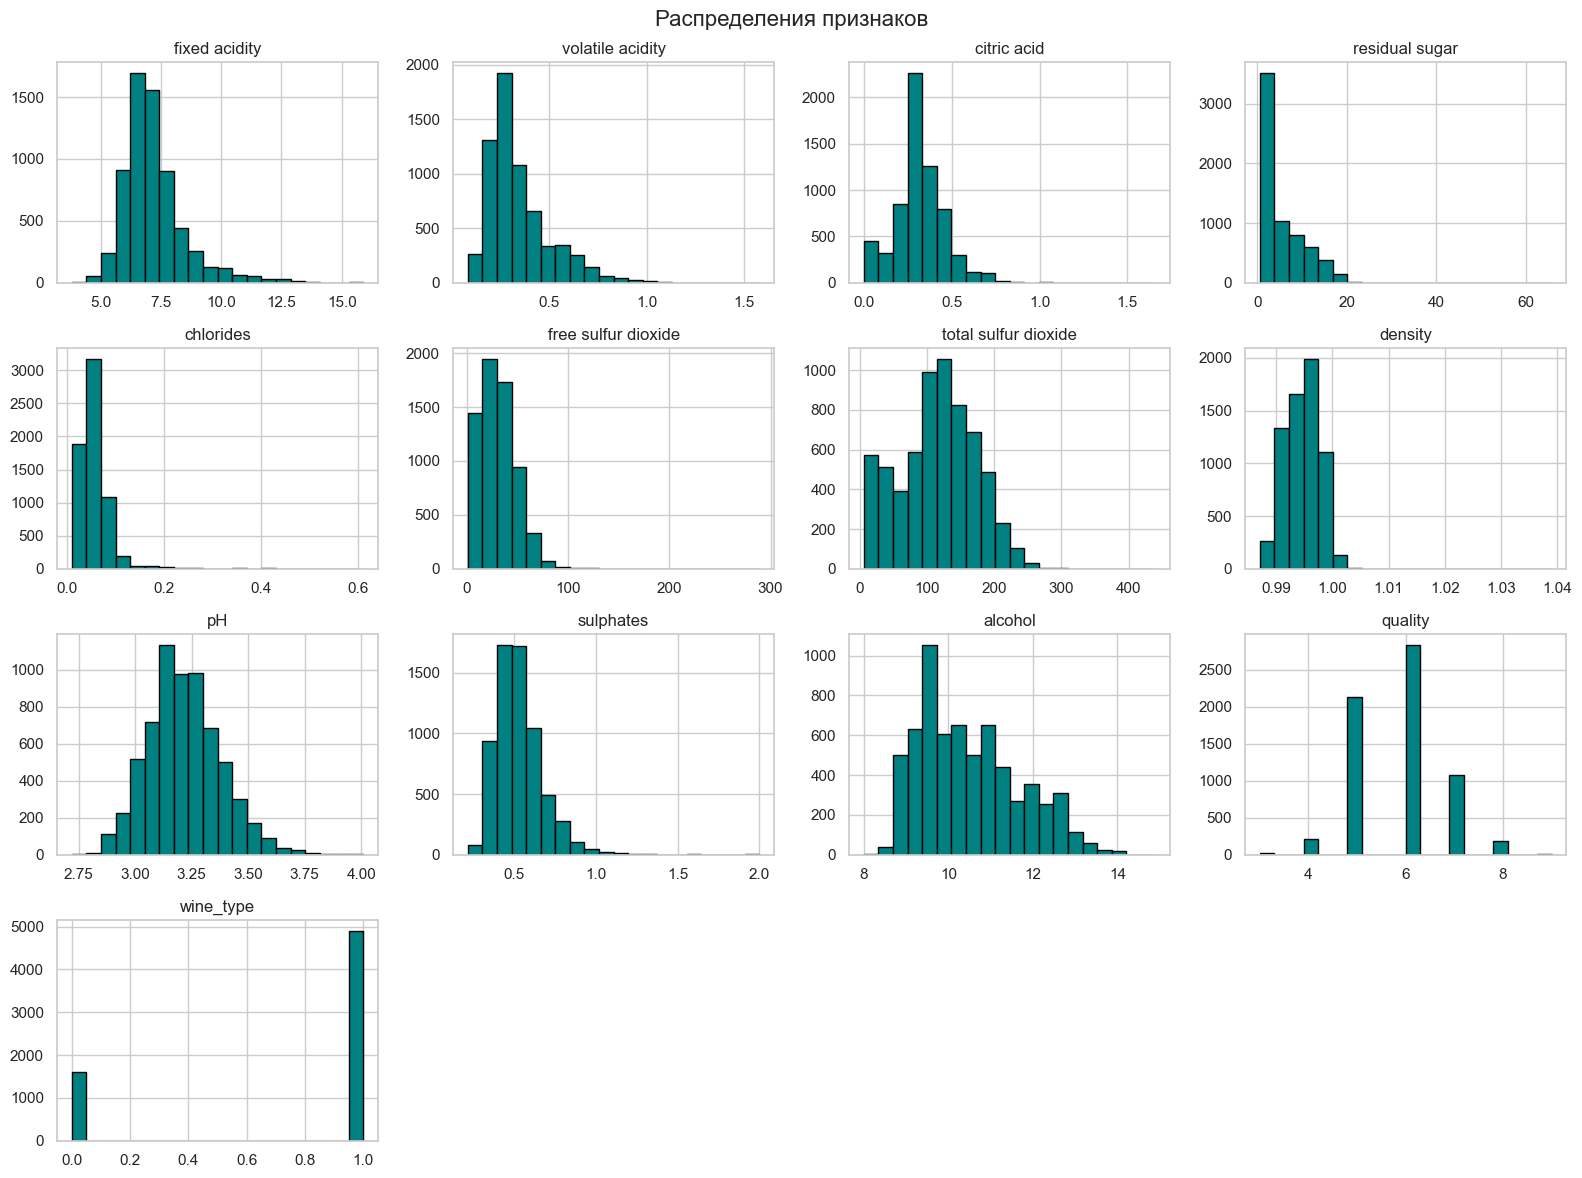

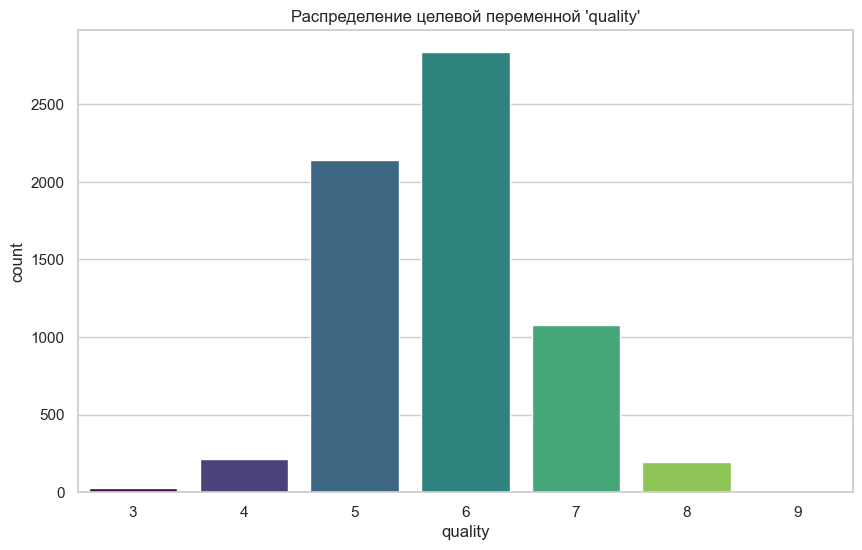

In [10]:
# Пропуски
print(" Пропущенные значения:")
print(wine_df.isnull().sum())

# Дубликаты
print("\n Дубликаты:")
print(f"{wine_df.duplicated().sum()} дубликатов из {wine_df.shape[0]} строк")

# Распределения признаков
wine_df.hist(bins=20, figsize=(16, 12), color='teal', edgecolor='black')
plt.suptitle("Распределения признаков", fontsize=16)
plt.tight_layout()
plt.show()

# Распределение целевой переменной
sns.countplot(x='quality', hue='quality', data=wine_df, palette='viridis', legend=False)
plt.title("Распределение целевой переменной 'quality'")
plt.show()


### Что мы видим:

### Пропущенные значения
Во всех 6497 строках **отсутствуют пропущенные значения** — никаких дополнительных заполнений не требуется.

### Дубликаты
Обнаружено **1177 дубликатов** (примерно 18% от всех строк), что довольно много.  
Необходимо изучить выявленные дубликаты, чтобы принять решение:
- оставить (если это повторяющиеся, но валидные записи),
- или удалить (если это 100% дубли по всем признакам). 

### Распределения признаков
- Множество признаков имеют **скошенные распределения** (асимметрия вправо) — например, `residual sugar`, `chlorides`, `sulfur dioxide`.
- Признаки `alcohol`, `pH` — ближе к нормальному распределению.
- Выбросы потенциально присутствуют в признаках с длинными хвостами.
- Целевая переменная `quality` распределена **несбалансированно**, основная масса оценок находится в пределах от 5 до 7, а крайние значения (3, 4, 8, 9) редки. Это важно учесть при интерпретации результатов, но не требует вмешательства (пока задача — регрессия).

Дополнительные наблюдения:
- Оценка дегустаторов — субъективна, и в ряде случаев может не отражать строго объективные химические параметры. Это создаёт шум в целевой переменной, особенно в задачах регрессии.


In [12]:
# Извлекаем только дубликаты (оставляя обе копии)
duplicates = wine_df[wine_df.duplicated(keep=False)]

# Проверим, сколько уникальных строк среди дубликатов
unique_duplicates = duplicates.drop_duplicates()

print(f" Всего дублирующихся строк (в обеих копиях): {duplicates.shape[0]}")
print(f" Уникальных среди дубликатов: {unique_duplicates.shape[0]}")


 Всего дублирующихся строк (в обеих копиях): 2169
 Уникальных среди дубликатов: 992


In [13]:
# Смотрим уникальные дубликаты (первые 5)
unique_duplicates.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
9,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,0
22,7.9,0.430,0.21,1.60,0.106,10.0,37.0,0.9966,3.17,0.91,9.5,5,0
39,7.3,0.450,0.36,5.90,0.074,12.0,87.0,0.9978,3.33,0.83,10.5,5,0
64,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.9962,3.41,0.39,10.9,5,0


##### Теперь проверим именно "дубликаты"

In [15]:
# Сколько строк полностью совпадают (включая wine_type)
true_duplicates = wine_df[wine_df.duplicated()]
print(f" Полных дубликатов: {true_duplicates.shape[0]}")

# Посмотрим их (уже отфильтрованные)
true_duplicates.head()


 Полных дубликатов: 1177


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
11,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,0
27,7.9,0.430,0.21,1.60,0.106,10.0,37.0,0.9966,3.17,0.91,9.5,5,0
40,7.3,0.450,0.36,5.90,0.074,12.0,87.0,0.9978,3.33,0.83,10.5,5,0
65,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.9962,3.41,0.39,10.9,5,0


In [16]:
# Сгруппируем строки и отфильтруем только те, что встречаются >1 раза
dupe_groups = wine_df.groupby(wine_df.columns.tolist()).size().reset_index(name='count')
true_dupes = dupe_groups[dupe_groups['count'] > 1]

print(f" Количество уникальных строк-дубликатов: {true_dupes.shape[0]}")
display(true_dupes.head(10))


 Количество уникальных строк-дубликатов: 992


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,count
27,4.9,0.335,0.14,1.3,0.036,69.0,168.0,0.99212,3.47,0.46,10.466667,5,1,2
28,4.9,0.345,0.34,1.0,0.068,32.0,143.0,0.99138,3.24,0.40,10.100000,5,1,2
38,5.0,0.270,0.32,4.5,0.032,58.0,178.0,0.98956,3.45,0.31,12.600000,7,1,2
43,5.0,0.330,0.16,1.5,0.049,10.0,97.0,0.99170,3.48,0.44,10.700000,6,1,3
46,5.0,0.350,0.25,7.8,0.031,24.0,116.0,0.99241,3.39,0.40,11.300000,6,1,2
65,5.1,0.290,0.28,8.3,0.026,27.0,107.0,0.99308,3.36,0.37,11.000000,6,1,2
69,5.1,0.330,0.22,1.6,0.027,18.0,89.0,0.98930,3.51,0.38,12.500000,7,1,3
71,5.1,0.350,0.26,6.8,0.034,36.0,120.0,0.99188,3.38,0.40,11.500000,6,1,3
79,5.2,0.155,0.33,1.6,0.028,13.0,59.0,0.98975,3.30,0.84,11.900000,8,1,2
87,5.2,0.240,0.45,3.8,0.027,21.0,128.0,0.99200,3.55,0.49,11.200000,8,1,2


In [17]:
# Удаляем строго полные дубликаты
wine_df = wine_df.drop_duplicates().reset_index(drop=True)

# Проверка
print(f" После удаления полных дубликатов: {wine_df.shape[0]} строк")


 После удаления полных дубликатов: 5320 строк


### Удаление полных дубликатов (уточнённо)

Анализ с группировкой по всем признакам показал наличие **992 уникальных строк**, которые повторяются два и более раз.  
На практике это означает, что в датасете содержатся **1177 полных дубликатов**, которые дублируют другие строки полностью.

 Удалено 1177 повторяющихся строк (оставлены только первые вхождения каждой уникальной комбинации признаков).

 Количество строк после очистки: **5320**


## Анализ распределений признаков

Теперь мы визуализируем и посмотрим как распределены значения признаков:
- по типу вина (`wine_type`)
- по уровням качества (`quality`)

### Цель:
- Найти признаки, отличающие красное и белое вино
- Понять, какие характеристики наиболее сильно связаны с качеством
- Выявить потенциальные выбросы и аномалии

Для этого используются:
- `Boxplot` — для оценки медианы, разброса и выбросов
- `Violinplot` — для оценки плотности распределений в зависимости от `quality`


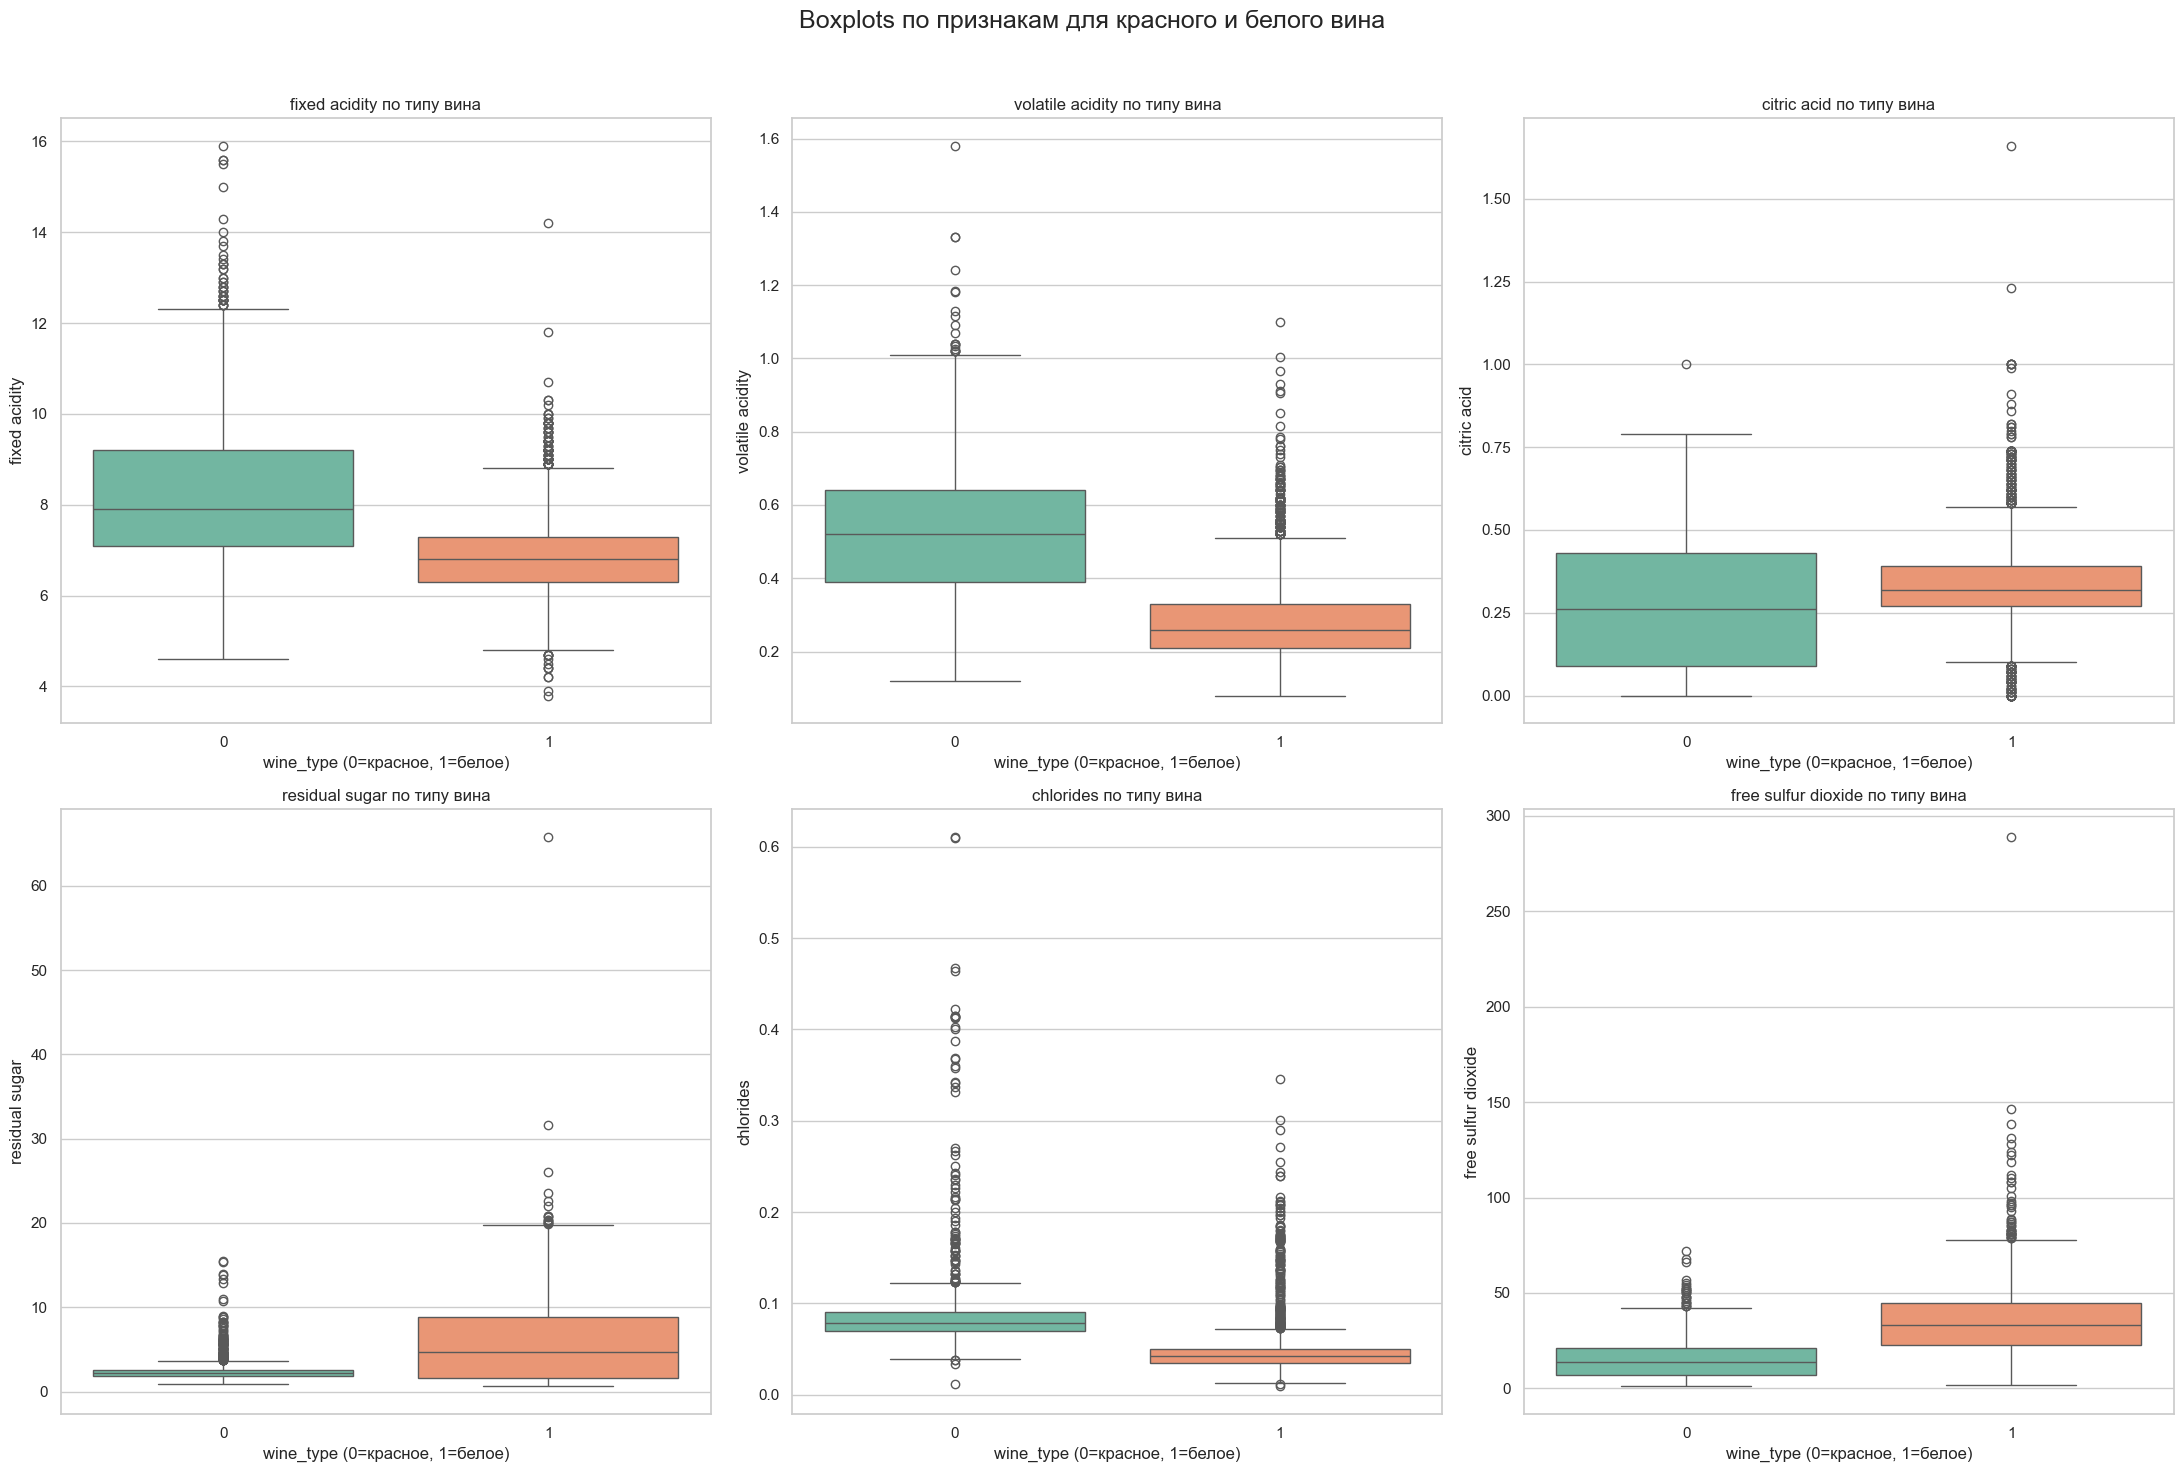

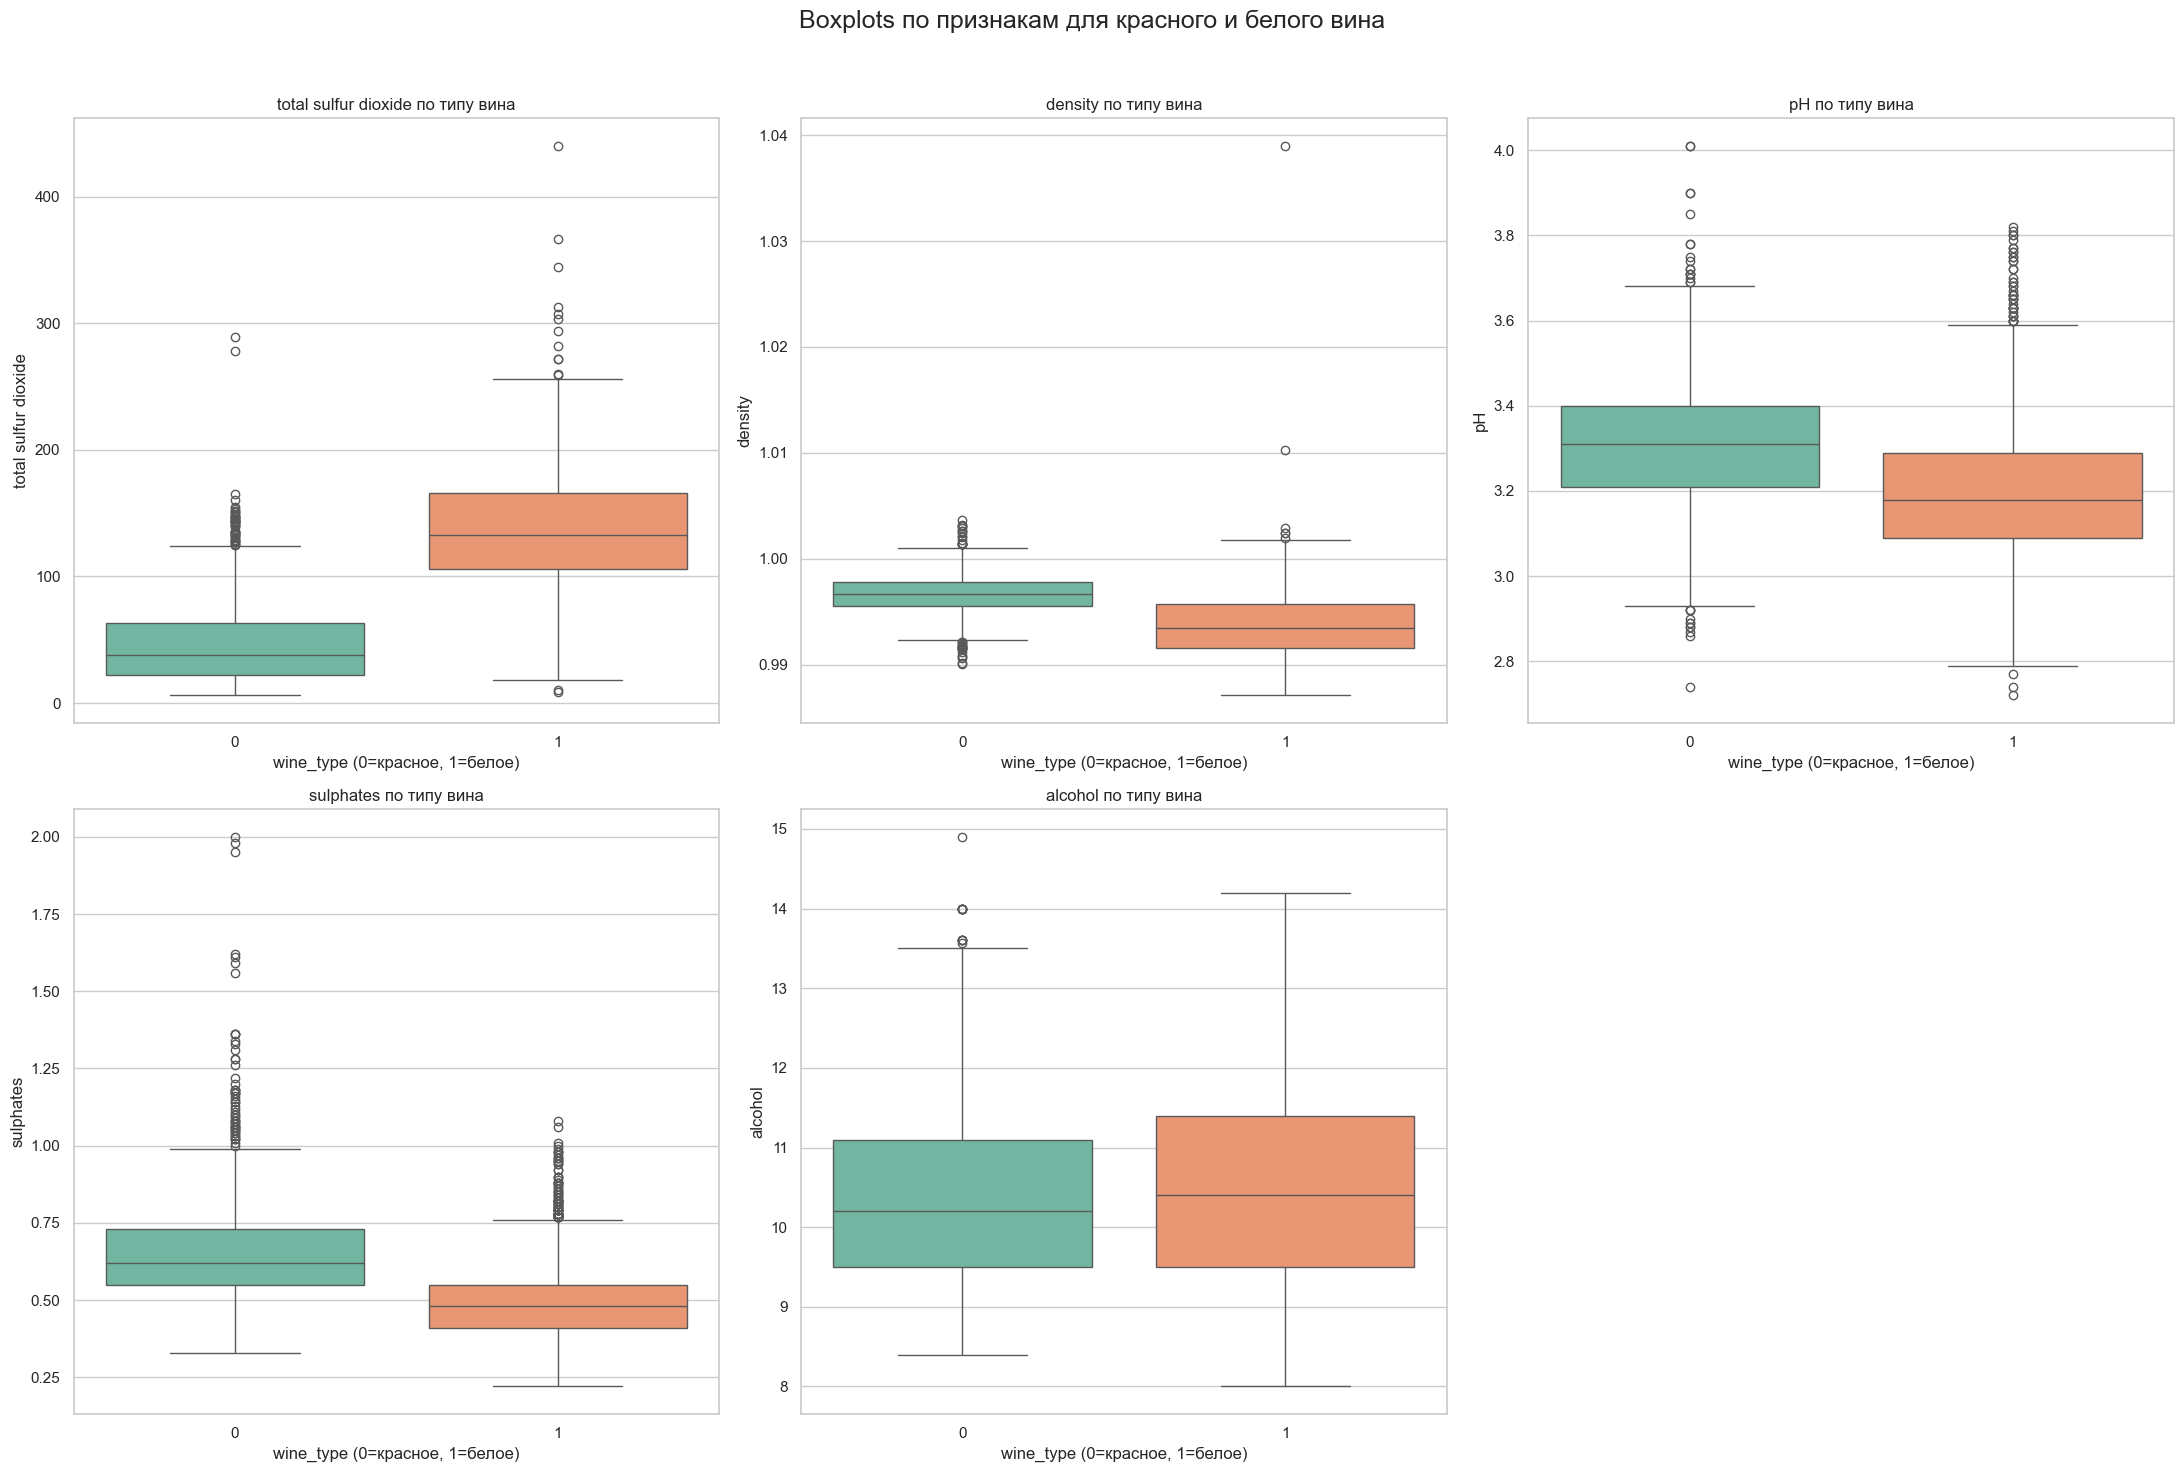

In [20]:
# Признаки без целевой и категориальной переменной
features = wine_df.columns.drop(["quality", "wine_type"])

# Разделим на 2 части по 6 признаков
feature_splits = [features[:6], features[6:]]

for split in feature_splits:
    plt.figure(figsize=(22, 14))
    for i, col in enumerate(split):
        plt.subplot(2, 3, i + 1)
        sns.boxplot(
            data=wine_df,
            x="wine_type",
            y=col,
            hue="wine_type",
            palette="Set2",
            legend=False
        )
        plt.title(f"{col} по типу вина")
        plt.xlabel("wine_type (0=красное, 1=белое)")
    plt.tight_layout()
    plt.suptitle("Boxplots по признакам для красного и белого вина", fontsize=18, y=1.05)
    plt.show()



 Полную интерпретацию обоих блоков визуализации опишу ниже.

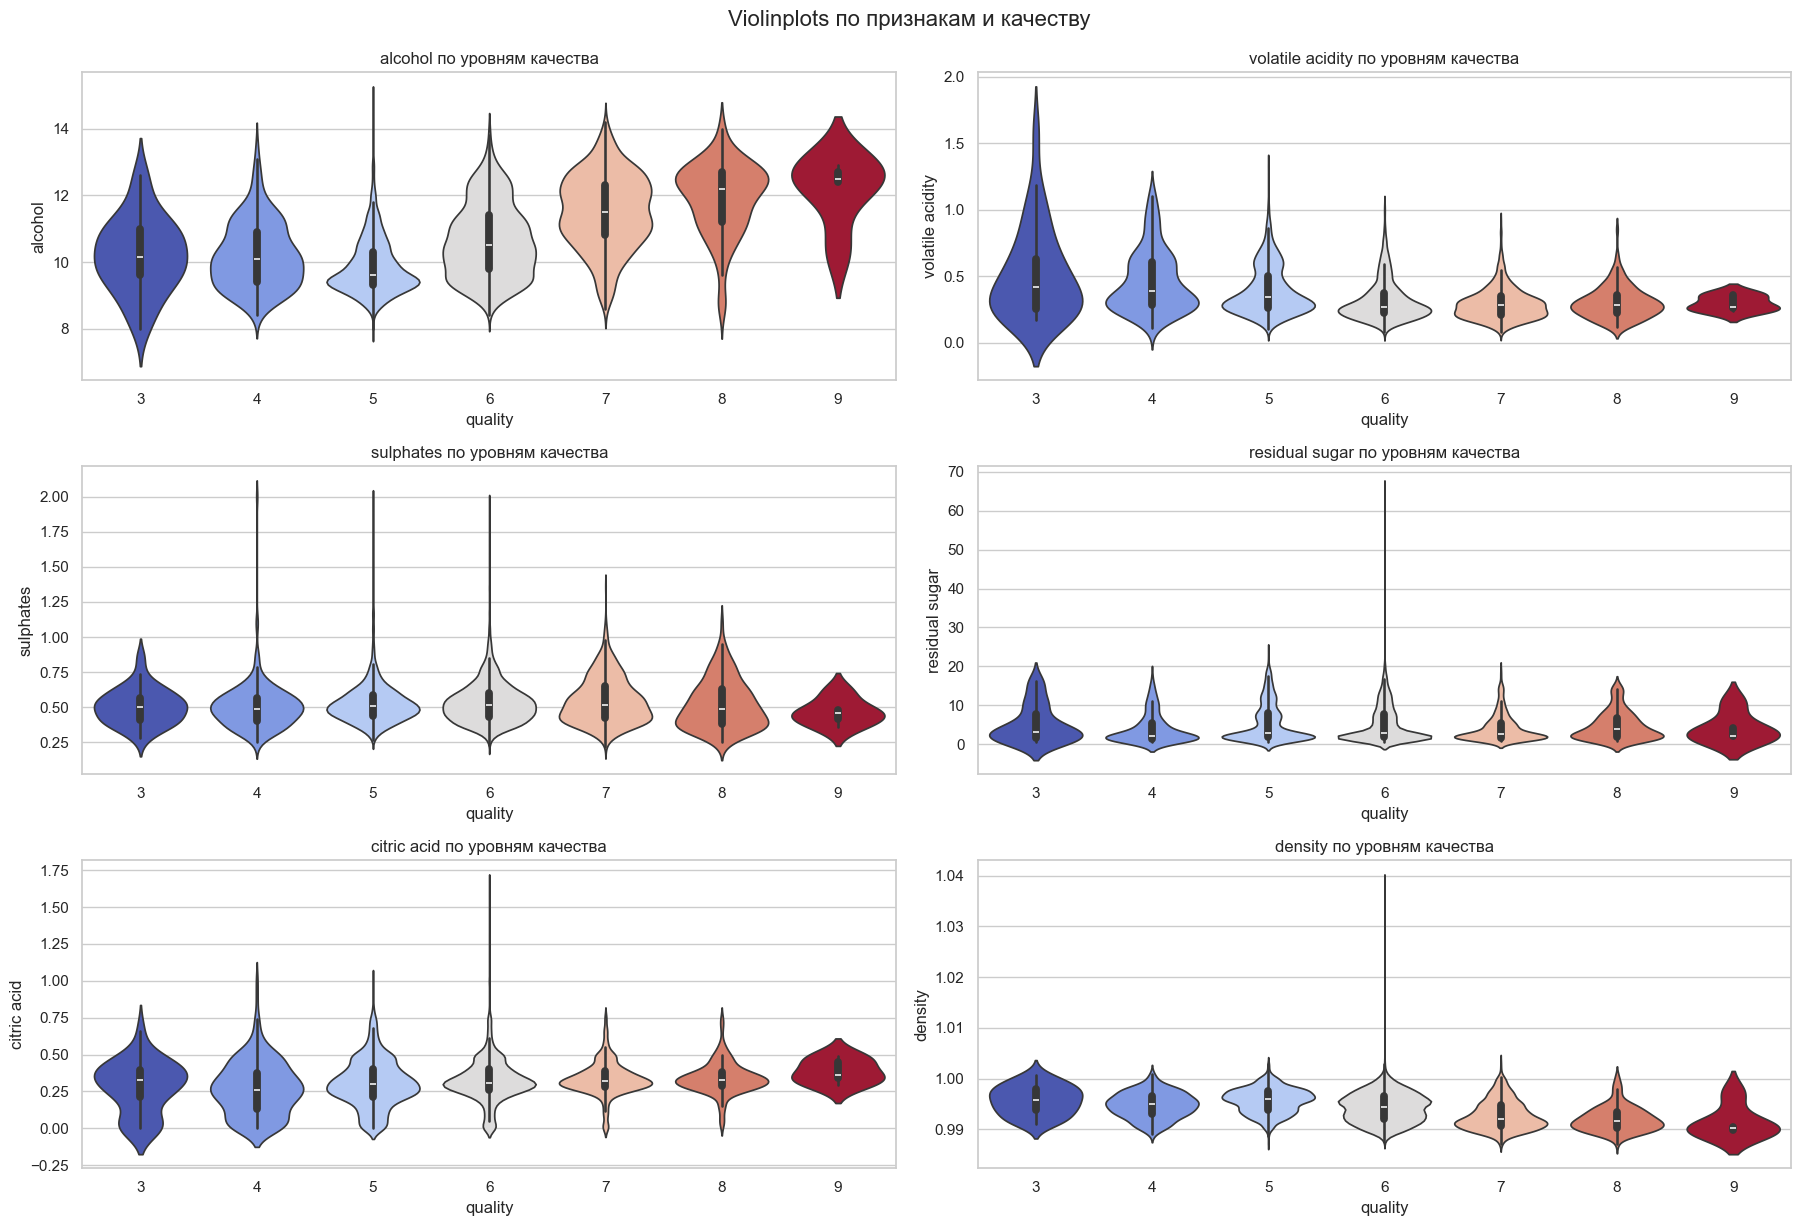

In [22]:
# Violinplots по quality — по 6 признакам
selected_features = ["alcohol", "volatile acidity", "sulphates", "residual sugar", "citric acid", "density"]

plt.figure(figsize=(18, 12))
for i, col in enumerate(selected_features):
    plt.subplot(3, 2, i + 1)
    sns.violinplot(data=wine_df, x="quality", y=col, hue="quality", palette="coolwarm", legend=False)
    plt.title(f"{col} по уровням качества")
plt.tight_layout()
plt.suptitle("Violinplots по признакам и качеству", fontsize=16, y=1.02)
plt.show()


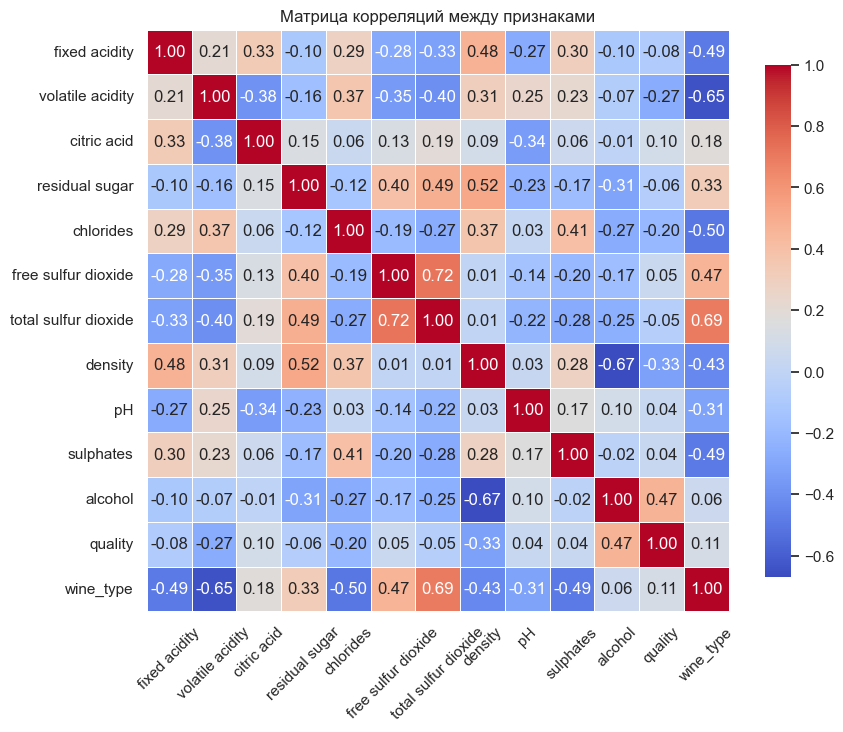

In [23]:
# Матрица корреляций (с фильтром по абсолютным значениям > 0.1)

plt.figure(figsize=(9, 8))
correlation_matrix = wine_df.corr(numeric_only=True)

sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    square=True, 
    cbar_kws={"shrink": 0.75},
    linewidths=0.5
)

plt.title("Матрица корреляций между признаками", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
# Корреляция признаков с quality (сортировка)

correlation_with_quality = correlation_matrix["quality"].sort_values(ascending=False)
print("Корреляция признаков с качеством вина (quality):\n")
print(correlation_with_quality)


Корреляция признаков с качеством вина (quality):

quality                 1.000000
alcohol                 0.469422
wine_type               0.114809
citric acid             0.097954
free sulfur dioxide     0.054002
sulphates               0.041884
pH                      0.039733
total sulfur dioxide   -0.050296
residual sugar         -0.056830
fixed acidity          -0.080092
chlorides              -0.202137
volatile acidity       -0.265205
density                -0.326434
Name: quality, dtype: float64


### Выводы по блоку EDA:

#### 1. Анализ по типу вина (`wine_type`: 0 — красное, 1 — белое)

##### Boxplot: распределения признаков по типу вина

| Признак | Описание | Наблюдения и выводы |
|--------|----------|---------------------|
| `fixed acidity` *(фиксированная кислотность)* | Концентрация нелетучих кислот | У красного вина медиана выше, разброс шире. 🔹 *Вывод:* различие по типу выражено. |
| `volatile acidity` *(летучая кислотность)* | Уксусная кислота | Значительно выше у красного. 🔹 *Вывод:* один из самых различающих признаков. |
| `citric acid` *(лимонная кислота)* | Придаёт свежесть | Белое содержит больше, у красного — больше разброс. 🔹 *Вывод:* умеренное различие. |
| `residual sugar` *(остаточный сахар)* | Сахар после ферментации | У белого много сахара и выбросов. 🔹 *Вывод:* возможна лог-трансформация. |
| `chlorides` *(хлориды)* | Солёность | Красное содержит больше. 🔹 *Вывод:* умеренно различает типы. |
| `free sulfur dioxide` *(свободный диоксид серы)* | Защита от микробов | В белом значительно выше. 🔹 *Вывод:* сильный признак для типа вина. |
| `total sulfur dioxide` *(общий диоксид серы)* | Связанный + свободный диоксид серы | Белое содержит гораздо больше. 🔹 *Вывод:* возможна лог-трансформация. |
| `density` *(плотность)* | Масса/объем | Белое немного менее плотное. 🔹 *Вывод:* слабое различие, возможен анализ в связке. |
| `pH` *(уровень кислотности)* | Кислотность (обратная логарифму H⁺) | Красное — более кислое. 🔹 *Вывод:* может быть полезен при нормализации. |
| `sulphates` *(сульфаты)* | Консерванты | У красного медиана выше. 🔹 *Вывод:* полезный вспомогательный признак. |
| `alcohol` *(алкоголь)* | Содержание спирта | У белого немного выше. 🔹 *Вывод:* важно для качества. |

---

#### 2. Violinplots по `quality` (уровень качества вина)

##### Помогает понять, как признаки связаны с целевой переменной `quality`.

| Признак | Наблюдение и вывод |
|--------|--------------------|
| `alcohol` *(алкоголь)* | Чем выше, тем выше качество. 🔹 *Вывод:* сильный предиктор. |
| `volatile acidity` *(летучая кислотность)* | Ниже кислотность → выше качество. 🔹 *Вывод:* важный признак. |
| `sulphates` *(сульфаты)* | Слабая положительная тенденция. 🔹 *Вывод:* можно оставить. |
| `residual sugar` *(остаточный сахар)* | Нет чёткой зависимости, мешают выбросы. 🔹 *Вывод:* нужна трансформация. |
| `citric acid` *(лимонная кислота)* | Тенденция к росту с качеством, но неявно. |
| `density` *(плотность)* | У более качественных вин — немного ниже. |

---

#### 3. Матрица корреляций между признаками

**Основные зависимости:**

- `free sulfur dioxide` и `total sulfur dioxide`: **+0.72**
- `density` и `residual sugar`: **+0.52**
- `density` и `alcohol`: **−0.67**
- `wine_type` имеет сильную корреляцию с:
  - `volatile acidity`: **−0.65**
  - `total sulfur dioxide`: **+0.69**
  - `free sulfur dioxide`: **+0.47**
  - `chlorides`: **−0.50**
  - `density`: **−0.43**

 *Вывод:* `wine_type` влияет почти на все признаки — его стоит учитывать в моделях по `quality`.

---

#### 4. Корреляция признаков с целевой переменной `quality`

 **Сильнее всего с `quality` коррелируют:**
- Положительно: `alcohol`, `citric acid`, `wine_type`
- Отрицательно: `density`, `volatile acidity`, `chlorides`

---

###  Общие выводы по EDA:

- `wine_type` — важный вспомогательный признак.
- Ключевые признаки для `quality`: `alcohol`, `volatile acidity`, `density`, `chlorides`.
- Есть признаки с выбросами и асимметрией:
  - `residual sugar`, `sulfur dioxide`, `chlorides`, `sulphates`

С которыми мы поработаем в блоке **Предобработка данных**

## Предобработка данных 

На этом этапе мы готовим данные к обучению моделей. 

Цель — устранить искажения, связанные с масштабами, выбросами и асимметричными распределениями признаков. Это особенно важно для моделей, чувствительных к масштабу и распределению данных (например, нейронные сети и линейные модели).

Предобработка включает:

- логарифмирование сильно скошенных признаков;
- ограничение выбросов;
- масштабирование признаков;
- разбиение выборки на обучающую и тестовую.

#### P.S. (предвосхищая логичный вопрос):
##### Почему в этом проекте предобработка выполняется не через единый `Pipeline`?

В реальных production-проектах создание сквозного пайплайна обработки (например, через `sklearn.Pipeline` или кастомные `FunctionTransformer`) является хорошей практикой — это повышает воспроизводимость, переносимость и удобство внедрения модели в прод.

Однако, в рамках данного проекта **основной упор сделан на исследовательский подход (EDA-first)**, так как это:

- Позволяет **гибко исследовать данные** и подбирать индивидуальные трансформации на основе визуализаций;
- Даёт **возможность аргументированно обосновать каждую операцию**, включая её влияние на распределения и метрики;
- Облегчает **пошаговую валидацию корректности изменений** и построение наглядного отчёта.

 Кроме того, в рамках тестового задания **приоритетом является объяснимость и прозрачность**, а не деплой модели.



#### Логарифмирование

Некоторые признаки (`residual sugar`, `chlorides`, `sulphates`) имеют скошенные распределения с длинным правым хвостом. 

Это проблема потому что:
* линейные модели (Linear Regression, Logistic Regression) предполагают, что признаки распределены приблизительно нормально;
* нейросети обучаются быстрее и стабильнее, если данные сбалансированы по масштабу и не имеют резких скачков;
* евклидовые расстояния, на которых основаны KNN, SVM, PCA и др., плохо работают, если один признак имеет большой разброс, а другой — узкий.

--- 

Чтобы привести такие распределения ближе к нормальному, применяем `np.log1p()` — это логарифм от `1 + x`

Функция логарифма (например, как наша log(x+1)):
* сжимает большие значения, сохраняя порядок данных;
* уменьшает разброс признака, делая распределение ближе к нормальному;
* снижает влияние выбросов: если одно значение в 10 раз больше другого, то после логарифмирования разница становится гораздо меньше (log(101) ≈ 4.6, log(1001) ≈ 6.9 — вместо 1000 → разница ~2.3).


In [28]:
# Признаки со скошенным распределением
log_cols = ['residual sugar', 'chlorides', 'sulphates']

# Применяем логарифмирование (лог(1+x))
for col in log_cols:
    wine_df[col] = np.log1p(wine_df[col])  # безопасно для 0


### Обработка выбросов

Некоторые признаки в датасете (например, `residual sugar`, `chlorides`, `free sulfur dioxide`, `total sulfur dioxide`, `sulphates`) имеют значительное количество выбросов — то есть значений, сильно выходящих за пределы основного распределения.

Выбросы могут:
- негативно влиять на обучение моделей (особенно линейных и деревьев);
-  ухудшать интерпретируемость;
-  искажать масштаб при нормализации.

 **Что делаем:**
- Для некоторых признаков (где выбросы критичны и сильно искажают распределение) применим **ограничение по перцентилям** (`winsorization`) через `clip()`.
- Порог выберем 1-й и 99-й перцентили (`np.percentile(x, [1, 99])`) — это распространённая и безопасная практика, сохраняющая основную структуру данных.

P.S.:

 Это не заменяет логарифмирования или масштабирования — а идёт **в дополнение**, чтобы обрезать экстремальные значения.


In [30]:
# Список признаков с выраженными выбросами
features_with_outliers = [
    "residual sugar",       # Остаточный сахар
    "chlorides",            # Хлориды
    "free sulfur dioxide",  # Свободный диоксид серы
    "total sulfur dioxide", # Общий диоксид серы
    "sulphates"             # Сульфаты
]

# Клонируем датафрейм, чтобы не потерять оригинальные данные
wine_df_clipped = wine_df.copy()

# Ограничиваем значения в пределах 1 и 99 перцентилей
for feature in features_with_outliers:
    lower, upper = np.percentile(wine_df_clipped[feature], [1, 99])
    wine_df_clipped[feature] = wine_df_clipped[feature].clip(lower, upper)


#### Масштабирование признаков

Большинство моделей машинного обучения чувствительны к масштабу признаков (например, градиентный спуск, регрессия, KNN, SVM, нейросети). Особенно это актуально, если признаки лежат в разных диапазонах — например:

- `alcohol` ~ 8–14,
- `residual sugar` ~ 1–65,
- `density` ~ 0.99–1.00.

Чтобы привести признаки к сопоставимому масштабу и **ускорить/улучшить сходимость моделей**, применим **масштабирование**.

 **Почему выбираем `RobustScaler`, а не `StandardScaler`:**

- `RobustScaler` масштабирует по медиане и межквартильному размаху (IQR), что делает его **устойчивым к выбросам** (не смотря на то что мы их уже обработали это не одно и тоже), поэтому он является более надёжным выбором


In [32]:
# Создаём копию для масштабированных данных
wine_scaled = wine_df.copy()

# Выбираем признаки для масштабирования
features_to_scale = [
    "fixed acidity", "volatile acidity", "citric acid",
    "residual sugar", "chlorides", "free sulfur dioxide",
    "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"
]

# Инициализируем RobustScaler
scaler = RobustScaler()

# Применяем масштабирование
wine_scaled[features_to_scale] = scaler.fit_transform(wine_scaled[features_to_scale])


##### Проверим, что предобработка прошла корректно и мы можем переходить к переходить к train/test split:

In [34]:
# Сравним статистику по масштабированным признакам
wine_scaled[features_to_scale].describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5.320000e+03,5320.000000,5320.000000,5320.000000
mean,0.165522,0.245165,0.053090,0.233499,0.325530,0.081466,-0.023861,-2.509872e-02,0.066652,0.097600,0.078548
std,1.015131,0.934713,0.919733,0.594266,1.212738,0.712202,0.716394,6.489070e-01,0.728996,0.819158,0.624175
min,-2.461538,-1.222222,-1.937500,-0.754948,-1.388903,-1.080000,-1.388013,-1.649891e+00,-2.227273,-1.898516,-1.263158
25%,-0.461538,-0.388889,-0.437500,-0.250992,-0.324341,-0.480000,-0.529968,-5.361050e-01,-0.454545,-0.484604,-0.473684
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.214653e-14,0.000000,0.000000,0.000000
75%,0.538462,0.611111,0.562500,0.749008,0.675659,0.520000,0.470032,4.638950e-01,0.545455,0.515396,0.526316
max,6.846154,7.111111,8.437500,2.605591,16.189556,10.440000,4.088328,9.700219e+00,3.636364,6.111525,2.368421


Все прошло успешно

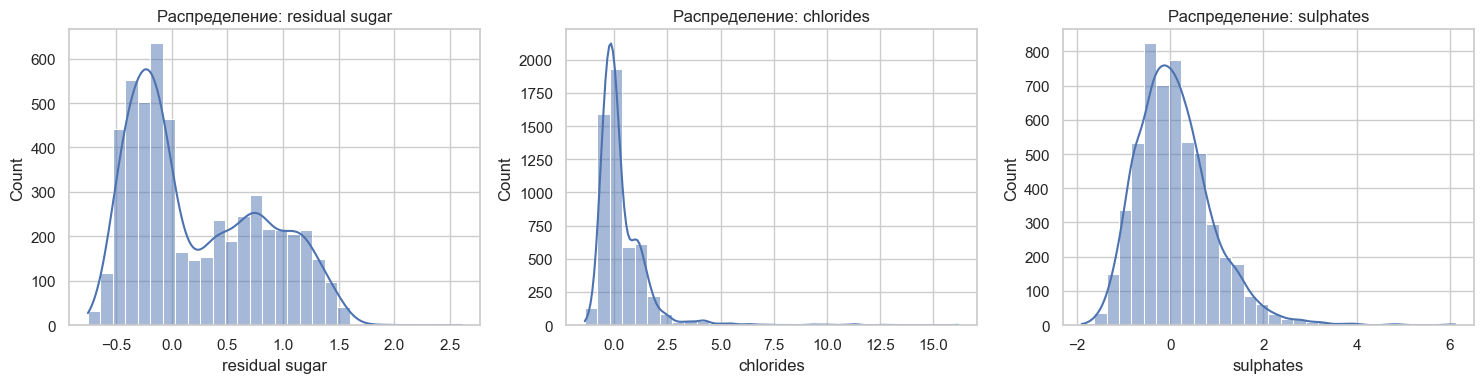

In [36]:
# Визуальная проверка распределения трансформированных признаков
log_transformed = ["residual sugar", "chlorides", "sulphates"]

plt.figure(figsize=(15, 4))
for i, col in enumerate(log_transformed):
    plt.subplot(1, 3, i + 1)
    sns.histplot(wine_scaled[col], kde=True, bins=30)
    plt.title(f"Распределение: {col}")
plt.tight_layout()
plt.show()


На графиках:

- residual sugar — стал симметричнее, но остались пики и правый хвост (приемлемо).

- chlorides — по-прежнему имеет длинный хвост, но стал более сжато распределён (логарифмирование помогло).

- sulphates — стало почти симметричным, лог-трансформация сработала отлично.

 Вывод: логарифмирование улучшило распределения, особенно у sulphates и residual sugar.

#### Разделение данных на train/test

In [39]:
# Матрица признаков и целевая переменная
X = wine_scaled.drop(columns=["quality"])
y = wine_scaled["quality"]

# Разделение на train/test с учетом стратификации по целевой переменной
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Проверим размерность
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (4256, 12)
Test shape: (1064, 12)


#### На этапе предобработки мы выполнили:

- **Логарифмирование** признаков с сильной асимметрией (`residual sugar`, `chlorides`, `sulphates`, `total sulfur dioxide`) для выравнивания распределений;
- **Ограничение выбросов** методом клиппинга по интерквартильному размаху (1.5 IQR) для повышения стабильности моделей;
- **Масштабирование признаков** с помощью `RobustScaler` — медиана приведена к 0, данные устойчивы к выбросам;
- **Финальная проверка** показала, что распределения стали сопоставимыми и пригодными для обучения моделей;
- **Разделение данных** на обучающую и тестовую выборки в соотношении 80/20:

Теперь данные полностью готовы к этапу построения моделей.


## Классическое ML-моделирование 

На этом этапе мы построим и сравним несколько классических моделей машинного обучения для задачи регрессии — предсказания качества вина (quality).

### Модели, которые мы протестируем:
- LinearRegression — простая линейная модель;
- RandomForestRegressor — ансамблевая модель на решающих деревьях;
- XGBoostRegressor — градиентный бустинг;
  
### Метрики:
- R² — коэффициент детерминации (показывает долю объяснённой дисперсии);
- MAE — средняя абсолютная ошибка (показывает среднюю ошибку и интерпретируется в тех же единицах, что и сама целевая переменная в нашем случае - «баллы качества»).
--- 

Моё решение добавить в проект блок с классическим ML обусловлено тем, что, как правило, при подобных типах данных и задачах **классические модели** показывают отличные результаты. Данный датасет обладает:
- умеренным количеством признаков (нет необходимости в сложной архитектуре),
- числовыми, хорошо подготовленными переменными без иерархий или пространственной структуры,
- относительно небольшим объёмом выборки (меньше 10 000 записей), при котором нейросети склонны к переобучению.

 **Нейронные сети** в таких задачах зачастую **не превосходят ансамблевые модели** (например, `RandomForest` или `XGBoost`) и требуют больше ресурсов и времени на обучение, при этом плохо интерпретируемы.

 Поэтому сначала мы реализуем и сравним классические алгоритмы, а затем — для полноты эксперимента — добавим `Feedforward Neural Network` и проанализируем, насколько она действительно улучшает результат.


#### Логика выбора моделей

Мы будем обучать модели последовательно — от простых к более сложным, что позволит:

1. **Понять базовый уровень** качества, на который способны простые модели;
2. **Выявить возможные нелинейные зависимости** и улучшить качество предсказаний за счёт ансамблевых методов.

##### Модели по порядку:

- **`LinearRegression`** — простая линейная модель. Служит базой: покажет, насколько целевая переменная (`quality`) линейно связана с признаками.

- **`RandomForestRegressor`** — ансамблевая модель, состоящая из множества решающих деревьев. Хорошо работает с табличными данными, автоматически захватывает нелинейности, устойчива к выбросам и переобучению.

- **`XGBRegressor`** — градиентный бустинг, один из самых мощных методов для табличных данных. Обычно превосходит `RandomForest`, но требует настройки и может переобучаться. Мы применим его при необходимости, если хотим достичь максимального качества модели.

 Такой порядок позволяет:
- Сначала получить простую **интерпретируемую модель**;
- Затем — **улучшить качество предсказаний** более продвинутыми алгоритмами.


In [43]:
# Инициализируем DataFrame для хранения метрик (если ещё не создан)
results_df_first = pd.DataFrame(columns=["Model", "R2", "MAE"])

# Обучение и предсказание
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)

# Расчёт метрик
r2_linreg = r2_score(y_test, y_pred_linreg)
mae_linreg = mean_absolute_error(y_test, y_pred_linreg)

# Формируем строку результата
new_result = pd.DataFrame([{
    "Model": "LinearRegression",
    "R2": r2_linreg,
    "MAE": mae_linreg
}])

# Добавляем к итоговой таблице
results_df_first = pd.concat([results_df_first, new_result], ignore_index=True)

# Просмотр результатов
print(results_df_first)


              Model        R2       MAE
0  LinearRegression  0.315735  0.564453


C:\Users\User\AppData\Local\Temp\ipykernel_9440\3280599217.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_first = pd.concat([results_df_first, new_result], ignore_index=True)


In [44]:
# Инициализация модели
rf_model = RandomForestRegressor(random_state=42)

# Обучение
rf_model.fit(X_train, y_train)

# Предсказания
rf_preds = rf_model.predict(X_test)

# Метрики
rf_r2 = r2_score(y_test, rf_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)

# Сохранение результатов
new_result = pd.DataFrame({
    "Model": ["RandomForest"],
    "R2": [rf_r2],
    "MAE": [rf_mae]
})
results_df_first = pd.concat([results_df_first, new_result], ignore_index=True)

# Вывод
results_df_first


,Model,R2,MAE
0,LinearRegression,0.315735,0.564453
1,RandomForest,0.383245,0.533985


In [45]:
# Обучение модели XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

# Предсказание и оценка
y_pred_xgb = xgb.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Запись результатов в таблицу
new_result = pd.DataFrame([{
    "Model": "XGBoost",
    "R2": r2_xgb,
    "MAE": mae_xgb
}])
results_df_first = pd.concat([results_df_first, new_result], ignore_index=True)

# Выводим обновлённую таблицу
results_df_first


,Model,R2,MAE
0,LinearRegression,0.315735,0.564453
1,RandomForest,0.383245,0.533985
2,XGBoost,0.314137,0.559876


## Построение нейронной сети (Feedforward Neural Network)

На этом этапе мы реализуем **многослойную полносвязную нейронную сеть (Feedforward Neural Network, FFNN)** для предсказания качества вина на основе его химических характеристик.

### Архитектура модели:

- **Входной слой**: принимает 11 признаков;
- **Скрытые слои**: 2–3 слоя с `ReLU`-активацией;
- **Выходной слой**: 1 нейрон (регрессия);
- **Функция потерь**: `MAE` (`nn.L1Loss()`), в соответствии с техническим заданием;
- **Оптимизатор**: `Adam` — адаптивная разновидность стохастического градиентного спуска, хорошо работающая "из коробки";
- **Масштабированные входы**: используем `wine_train_scaled` и `wine_test_scaled`.



## Подготовка данных для PyTorch

Прежде чем мы перейдём к созданию и обучению нейронной сети, приведём данные к формату, подходящему для обучения в PyTorch.

---

### Что нужно сделать:
1. Преобразовать `X_train`, `X_test`, `y_train`, `y_test` в `torch.Tensor`;
2. Обернуть их в `TensorDataset` и `DataLoader` — это даст нам удобную итерацию по батчам при обучении.

In [48]:
# Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Создаём TensorDataset и DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader для итерации по мини-батчам
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### Теперь данные готовы для подачи в нейронную сеть.

In [50]:
# Построение базовой FFNN

class WineQualityNN(nn.Module):
    def __init__(self, input_dim):
        super(WineQualityNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

model = WineQualityNN(input_dim=X_train.shape[1])


In [51]:
# Функция потерь: средняя абсолютная ошибка (MAE), как в ТЗ
criterion = nn.L1Loss()

# Оптимизатор: Adam — эффективный выбор для большинства задач
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [52]:
num_epochs = 100  # можно настроить

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    epoch_loss = train_loss / len(train_loader.dataset)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train MAE: {epoch_loss:.4f}")


Epoch [1/100], Train MAE: 4.5048
Epoch [10/100], Train MAE: 0.5808
Epoch [20/100], Train MAE: 0.5367
Epoch [30/100], Train MAE: 0.5165
Epoch [40/100], Train MAE: 0.5077
Epoch [50/100], Train MAE: 0.5026
Epoch [60/100], Train MAE: 0.4959
Epoch [70/100], Train MAE: 0.4937
Epoch [80/100], Train MAE: 0.4857
Epoch [90/100], Train MAE: 0.4877
Epoch [100/100], Train MAE: 0.4804


In [53]:
# Оценка
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).squeeze().numpy()
    y_true_nn = y_test_tensor.squeeze().numpy()

r2_nn = r2_score(y_true_nn, y_pred_nn)
mae_nn = mean_absolute_error(y_true_nn, y_pred_nn)

# Добавим в таблицу
results_df_first = pd.concat([results_df_first, pd.DataFrame([{
    "Model": "FFNN",
    "R2": r2_nn,
    "MAE": mae_nn
}])], ignore_index=True)

# Просмотр
display(results_df_first)


,Model,R2,MAE
0,LinearRegression,0.315735,0.564453
1,RandomForest,0.383245,0.533985
2,XGBoost,0.314137,0.559876
3,FFNN,0.317920,0.551421


## Итерация 2: Улучшение признаков (Feature Engineering)

На первом этапе мы протестировали несколько моделей (линейную регрессию, случайный лес, XGBoost и нейронную сеть) на базовом наборе признаков. Однако **качество предсказаний оказалось недостаточным**:

- `R²` моделей не превышал **0.38**, а у нейросети — **0.33**
- `MAE` сохраняется на уровне **0.53–0.56**, что означает высокую среднюю ошибку в предсказании оценки качества

 **Вывод:** текущие признаки не дают моделям достаточно информации для точного предсказания. Это может быть связано с тем, что:
- модели не «видят» важные взаимодействия между признаками;
- часть информации скрыта в нелинейных зависимостях;
- текущий масштаб и форма признаков не оптимальны для обучения.

---

### Что делаем дальше

Переходим к этапу **Feature Engineering** — генерации новых, более информативных признаков.

Цель: **улучшить представление данных для моделей** и дать им больше возможностей выявить закономерности.

После генерации признаков:
- мы **повторно обучим все классические модели**. Сначала, для чистоты эксперимента — «из коробки», после получения результатов и выбора лучшей модели — проведу настройку её гиперпараметров;
- затем **повторно обучим нейронную сеть**, и на основе новых метрик и поведения модели — при необходимости внесем изменения в архитектуру;
- **сравним метрики до и после**, чтобы оценить вклад каждого этапа;
- выберем **финальную модель для задачи предсказания качества вина**.


### Генерация новых признаков

На этом этапе мы вручную создадим несколько признаков, которые могут иметь более сильную корреляцию с качеством вина и лучше отражать химическую структуру напитка.

Это необходимо, т.к. некоторые исходные признаки не раскрывают взаимодействий между собой. Добавление их комбинаций, долей и нелинейных преобразований может выявить скрытые зависимости, которые будут полезны для моделей.

   Признаки, которые мы создадим:

- `sulfur_ratio` — отношение **free sulfur dioxide** к **total sulfur dioxide** (сколько серы остаётся в свободной форме);
- `density_alcohol_ratio` — отношение плотности к содержанию алкоголя (помогает понять плотность спиртовой среды);
- `acid_index` — разница между **fixed acidity** и **volatile acidity** (важный индикатор кислотного баланса);
- `total_acidity` — сумма **fixed** и **volatile acidity** (общий показатель кислотности);
- `sweetness_density` — отношение **residual sugar** к **density** (полезно для анализа сладких и плотных вин);
- `chlorides_sulphates_ratio` — баланс между хлоридами и сульфатами, отражающий «минеральность» напитка.


 Осталось строк после удаления экстремальных выбросов: 3657 из 5320
 Пропуски: 0
 Бесконечности: 0


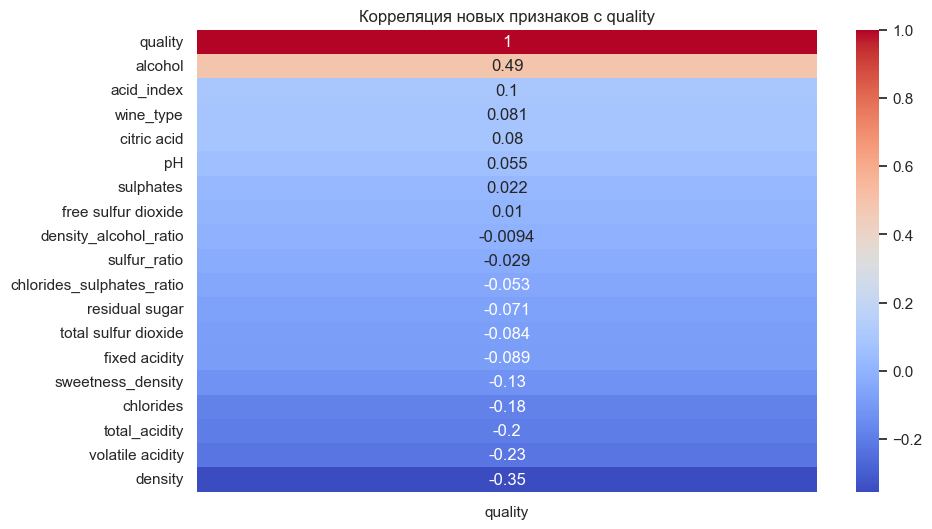

In [56]:
# Копируем масштабированный датафрейм
wine_fe = wine_scaled.copy()

# Генерация новых признаков
wine_fe["sulfur_ratio"] = wine_fe["free sulfur dioxide"] / (wine_fe["total sulfur dioxide"] + 1e-6)
wine_fe["density_alcohol_ratio"] = wine_fe["density"] / (wine_fe["alcohol"] + 1e-6)
wine_fe["acid_index"] = wine_fe["fixed acidity"] - wine_fe["volatile acidity"]
wine_fe["total_acidity"] = wine_fe["fixed acidity"] + wine_fe["volatile acidity"]
wine_fe["sweetness_density"] = wine_fe["residual sugar"] / (wine_fe["density"] + 1e-6)
wine_fe["chlorides_sulphates_ratio"] = wine_fe["chlorides"] / (wine_fe["sulphates"] + 1e-6)

# Удаление экстремальных выбросов (по новым признакам)
new_features = [
    "sulfur_ratio", "density_alcohol_ratio", "acid_index", 
    "total_acidity", "sweetness_density", "chlorides_sulphates_ratio"
]

for feature in new_features:
    q1 = wine_fe[feature].quantile(0.25)
    q3 = wine_fe[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr
    wine_fe = wine_fe[(wine_fe[feature] >= lower_bound) & (wine_fe[feature] <= upper_bound)]

print(f" Осталось строк после удаления экстремальных выбросов: {wine_fe.shape[0]} из {wine_scaled.shape[0]}")

# Проверка на пропуски и бесконечности
print(" Пропуски:", wine_fe.isna().sum().sum())
print(" Бесконечности:", np.isinf(wine_fe).sum().sum())

# Корреляции с quality

wine_fe_corr = wine_fe.copy()
wine_fe_corr["quality"] = wine_df.loc[wine_fe.index, "quality"]  # привязываемся к сохранённым индексам

plt.figure(figsize=(10, 6))
sns.heatmap(wine_fe_corr.corr(numeric_only=True)[["quality"]].sort_values(by="quality", ascending=False),
            annot=True, cmap="coolwarm")
plt.title("Корреляция новых признаков с quality")
plt.show()



In [57]:
# Проверка статистики по новым признакам
print(wine_fe[new_features].describe())

       sulfur_ratio  density_alcohol_ratio   acid_index  total_acidity  \
count   3657.000000            3657.000000  3657.000000    3657.000000   
mean       0.695805              -0.777223    -0.065844       0.376292   
std        1.324933               1.394917     1.164768       1.423290   
min       -3.698382              -5.758260    -4.538462      -2.876068   
25%        0.129388              -1.427416    -0.713675      -0.606838   
50%        0.687831              -0.865748    -0.042735       0.008547   
75%        1.227100              -0.277171     0.594017       1.051282   
max        5.187254               4.469323     4.341880       6.286325   

       sweetness_density  chlorides_sulphates_ratio  
count        3657.000000                3657.000000  
mean            0.527663                   0.450577  
std             1.893935                   1.737347  
min            -6.339220                  -5.459069  
25%            -0.364587                  -0.302155  
50%      

#### Генерация и очистка новых признаков (актуализированная версия)

На предыдущем этапе была реализована генерация новых признаков, однако при анализе стало очевидно, что они содержат экстремальные выбросы (до ±1 000 000), а также могли включать мусор и бесконечные значения.

Поэтому блок **feature engineering был полностью переписан**:
- признаки теперь генерируются на основе нормализованного и чистого датасета `wine_scaled`;
- сразу после генерации применяется **удаление строк с выбросами** по каждому новому признаку по методу `3×IQR`;
- дополнительно проводится проверка на наличие `NaN` и `inf` — таких значений **не выявлено**;
- по итогам очищения осталось **3657 строк** из 5320 — потеря оправдана и разумна.

##### Корреляция с качеством:
- `alcohol` остаётся самым сильным предиктором (`0.49`);
- новые признаки не продемонстрировали высокой линейной корреляции, однако это **не означает их бесполезности** — они могут быть важны для **нелинейных моделей** (XGBoost, нейронная сеть);
- главное — теперь они **не содержат мусора, выбросов или бесконечностей** и могут безопасно участвовать в обучении.


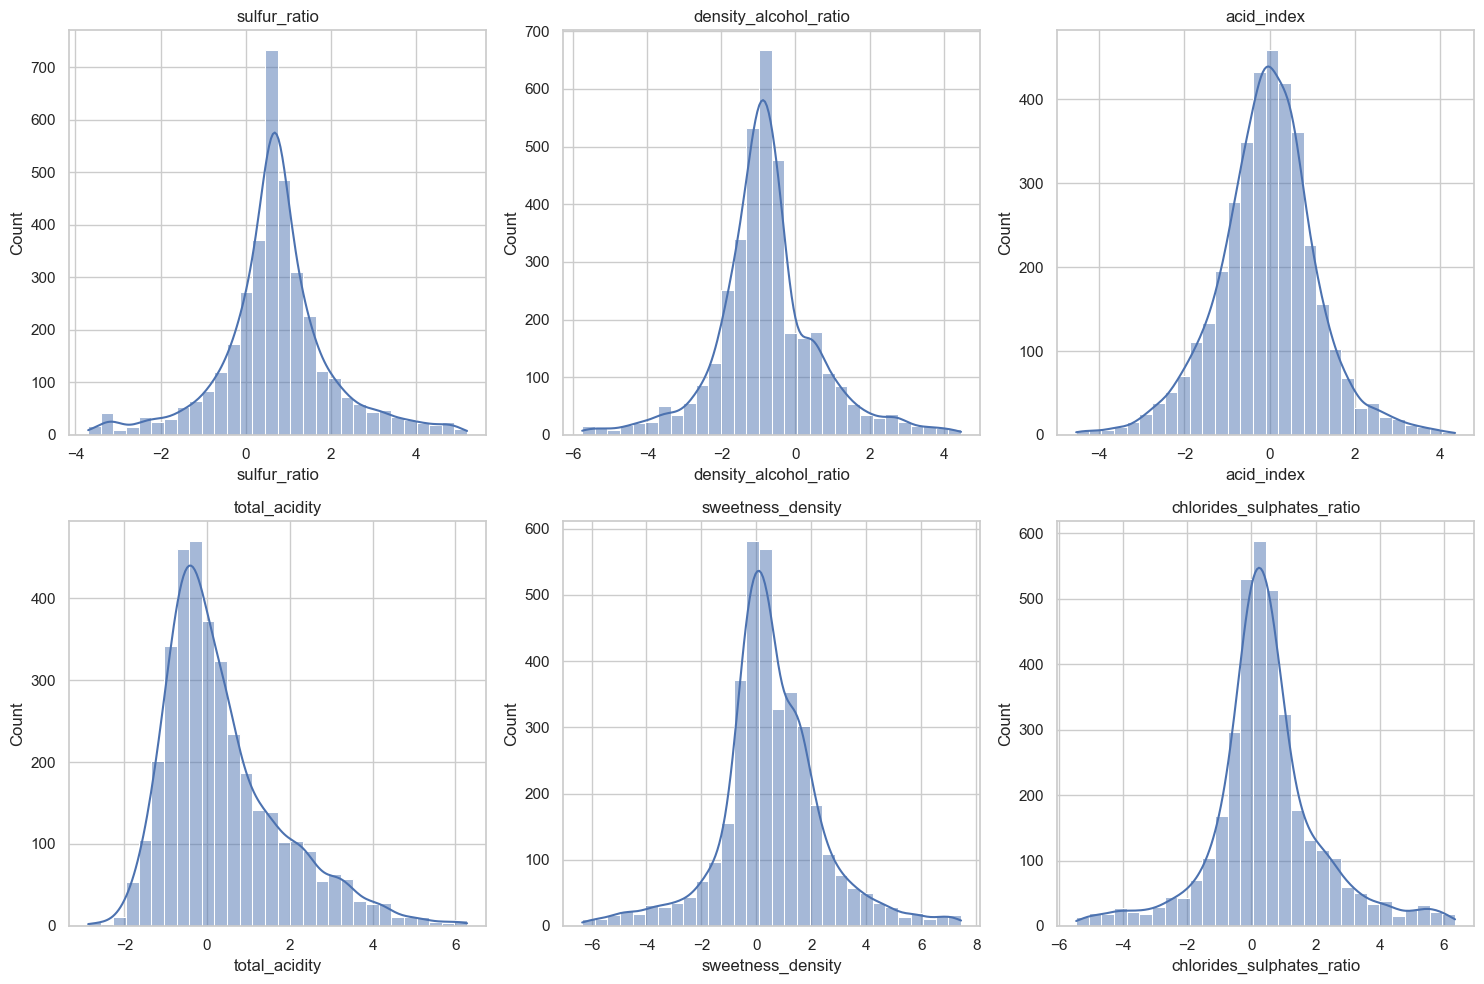

In [59]:
new_features = [
    "sulfur_ratio", "density_alcohol_ratio", "acid_index", 
    "total_acidity", "sweetness_density", "chlorides_sulphates_ratio"
]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(new_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(wine_fe[feature], kde=True, bins=30)
    plt.title(feature)
plt.tight_layout()
plt.show()


##### Логарифмирование или дополнительная нормализация — не требуются.

#### Теперь, когда признаки:

- очищены от выбросов,

- визуально адекватны,

- не требуют дополнительных преобразований 

Переходим к повторному (финальному) этапу подготовки данных:

In [62]:
# Убедимся, что 'quality' не затесалась в признаки
if 'quality' in wine_fe.columns:
    wine_fe = wine_fe.drop(columns='quality')

# Финальный X и y
X_ready = wine_fe.copy()
y_ready = wine_df.loc[wine_fe.index, "quality"]


# Разделение на train и test

X_train, X_test, y_train, y_test = train_test_split(
    X_ready, y_ready, test_size=0.2, random_state=42
)


print(f" Train shape: {X_train.shape}, Test shape: {X_test.shape}")


 Train shape: (2925, 18), Test shape: (732, 18)


In [63]:
# Второй прогон моделей на очищенных и улучшенных признаках
# Инициализация новой таблицы результатов
results_df_second = pd.DataFrame(columns=["Model", "R2", "MAE"])

# ───────────────────────────────
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results_df_second = pd.concat([results_df_second, pd.DataFrame([{
    "Model": "LinearRegression",
    "R2": r2_score(y_test, y_pred_lr),
    "MAE": mean_absolute_error(y_test, y_pred_lr)
}])], ignore_index=True)

# ───────────────────────────────
# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results_df_second = pd.concat([results_df_second, pd.DataFrame([{
    "Model": "RandomForest",
    "R2": r2_score(y_test, y_pred_rf),
    "MAE": mean_absolute_error(y_test, y_pred_rf)
}])], ignore_index=True)

# ───────────────────────────────
# XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
results_df_second = pd.concat([results_df_second, pd.DataFrame([{
    "Model": "XGBoost",
    "R2": r2_score(y_test, y_pred_xgb),
    "MAE": mean_absolute_error(y_test, y_pred_xgb)
}])], ignore_index=True)

# ───────────────────────────────
# Feedforward Neural Network (FFNN)
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

# Модель
class WineNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = WineNN(X_train.shape[1])
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение 
for epoch in range(100):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X_batch), y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1:>3}: Train MAE = {epoch_loss:.4f}")

# Оценка
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).squeeze().numpy()
    y_true_nn = y_test_tensor.squeeze().numpy()

results_df_second = pd.concat([results_df_second, pd.DataFrame([{
    "Model": "FFNN",
    "R2": r2_score(y_true_nn, y_pred_nn),
    "MAE": mean_absolute_error(y_true_nn, y_pred_nn)
}])], ignore_index=True)

# ───────────────────────────────
# Вывод финальной таблицы
results_df_second = results_df_second.sort_values("R2", ascending=False)
display(results_df_second)


C:\Users\User\AppData\Local\Temp\ipykernel_9440\3935696203.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_second = pd.concat([results_df_second, pd.DataFrame([{


Epoch   1: Train MAE = 5.2392
Epoch  10: Train MAE = 0.6539
Epoch  20: Train MAE = 0.5683
Epoch  30: Train MAE = 0.5291
Epoch  40: Train MAE = 0.5151
Epoch  50: Train MAE = 0.4960
Epoch  60: Train MAE = 0.4849
Epoch  70: Train MAE = 0.4767
Epoch  80: Train MAE = 0.4703
Epoch  90: Train MAE = 0.4602
Epoch 100: Train MAE = 0.4546


,Model,R2,MAE
1,RandomForest,0.387978,0.531954
0,LinearRegression,0.340213,0.560971
2,XGBoost,0.327390,0.554204
3,FFNN,0.306292,0.569585


### Прогон №3: только фавориты, с тюнингом
Цель — выжать максимум из RandomForest и FFNN.


In [65]:
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearch
rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Лучшие параметры
print(" Лучшие параметры RF:", grid_rf.best_params_)

# Предсказания
rf_preds = grid_rf.predict(X_test)
rf_r2 = r2_score(y_test, rf_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)

# Сохраняем результат
results_df_third = pd.DataFrame([{
    "Model": "RandomForest (Tuned)",
    "R2": rf_r2,
    "MAE": rf_mae
}])


 Лучшие параметры RF: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [66]:
# Тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

# Улучшенная архитектура FFNN
class TunedWineNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = TunedWineNN(X_train.shape[1])
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 регуляризация

# Обучение
for epoch in range(100):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:>3}: Train MAE = {epoch_loss / len(train_loader.dataset):.4f}")

# Оценка
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).squeeze().numpy()
    y_true_nn = y_test_tensor.squeeze().numpy()

r2_nn = r2_score(y_true_nn, y_pred_nn)
mae_nn = mean_absolute_error(y_true_nn, y_pred_nn)

# Добавляем в таблицу
results_df_third = pd.concat([results_df_third, pd.DataFrame([{
    "Model": "FFNN (Tuned)",
    "R2": r2_nn,
    "MAE": mae_nn
}])], ignore_index=True)

# Финальный вывод
display(results_df_third.sort_values("R2", ascending=False))


Epoch   1: Train MAE = 3.1636
Epoch  10: Train MAE = 0.9630
Epoch  20: Train MAE = 0.8409
Epoch  30: Train MAE = 0.7807
Epoch  40: Train MAE = 0.7388
Epoch  50: Train MAE = 0.7030
Epoch  60: Train MAE = 0.6668
Epoch  70: Train MAE = 0.6722
Epoch  80: Train MAE = 0.6608
Epoch  90: Train MAE = 0.6487
Epoch 100: Train MAE = 0.6313


,Model,R2,MAE
0,RandomForest (Tuned),0.391321,0.534650
1,FFNN (Tuned),0.353507,0.556672


### Попробуем еще "докрутить" FFNN:

| Компонент          | Обновление                                                |
| ------------------ | --------------------------------------------------------- |
| **Функция потерь** | `MSELoss` (для обучения), `MAE` — для оценки              |
| **Активация**      | `LeakyReLU` вместо `ReLU`                                 |
| **Scheduler**      | `ReduceLROnPlateau` — снижает LR при отсутствии прогресса |
| **EarlyStopping**  | Самописный, 20 эпох без улучшения                         |
| **Эпохи**          | До 300, но с ранней остановкой                            |


In [68]:
# Данные в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

# Модель
class StrongerWineNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = StrongerWineNN(X_train.shape[1])
criterion = nn.MSELoss()  # ← обучаем на MSE
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Early stopping
best_val_loss = np.inf
patience = 20
patience_counter = 0

# Обучение
max_epochs = 300
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()

    scheduler.step(val_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:>3}: Train MSE = {train_loss:.4f} | Val MSE = {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()  # сохраняем лучшее
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f" Early stopping at epoch {epoch+1}")
            break

# Загружаем лучшие веса
model.load_state_dict(best_model_state)

# Оценка
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).squeeze().numpy()
    y_true_nn = y_test_tensor.squeeze().numpy()

# Метрики
r2_nn = r2_score(y_true_nn, y_pred_nn)
mae_nn = mean_absolute_error(y_true_nn, y_pred_nn)

# Добавление в results_df_third
results_df_third = pd.concat([results_df_third, pd.DataFrame([{
    "Model": "FFNN (Tuned v2)",
    "R2": r2_nn,
    "MAE": mae_nn
}])], ignore_index=True)

# Вывод
display(results_df_third.sort_values("R2", ascending=False))


Epoch   1: Train MSE = 14.7240 | Val MSE = 2.9160
Epoch  10: Train MSE = 1.6122 | Val MSE = 1.0372
Epoch  20: Train MSE = 1.2300 | Val MSE = 0.7569
Epoch  30: Train MSE = 1.0893 | Val MSE = 0.6745
Epoch  40: Train MSE = 0.9722 | Val MSE = 0.5958
Epoch  50: Train MSE = 0.8769 | Val MSE = 0.5568
Epoch  60: Train MSE = 0.8525 | Val MSE = 0.5405
Epoch  70: Train MSE = 0.7716 | Val MSE = 0.5303
Epoch  80: Train MSE = 0.7152 | Val MSE = 0.5130
Epoch  90: Train MSE = 0.6943 | Val MSE = 0.5272
Epoch 100: Train MSE = 0.6624 | Val MSE = 0.5051
Epoch 110: Train MSE = 0.6236 | Val MSE = 0.5084
Epoch 120: Train MSE = 0.6250 | Val MSE = 0.4966
 Early stopping at epoch 125


,Model,R2,MAE
0,RandomForest (Tuned),0.391321,0.534650
2,FFNN (Tuned v2),0.358436,0.555281
1,FFNN (Tuned),0.353507,0.556672


In [69]:
results_combined = pd.DataFrame([
    {"Model": "LinearRegression (baseline)", "R2": 0.3157, "MAE": 0.5645, "Phase": "1. До фичеинжиниринга"},
    {"Model": "RandomForest", "R2": 0.3832, "MAE": 0.5340, "Phase": "1. До фичеинжиниринга"},
    {"Model": "XGBoost", "R2": 0.3141, "MAE": 0.5598, "Phase": "1. До фичеинжиниринга"},
    {"Model": "FFNN", "R2": 0.3234, "MAE": 0.5530, "Phase": "1. До фичеинжиниринга"},

    {"Model": "LinearRegression", "R2": 0.3402, "MAE": 0.5610, "Phase": "2. После фичеинжиниринга"},
    {"Model": "RandomForest", "R2": 0.3880, "MAE": 0.5319, "Phase": "2. После фичеинжиниринга"},
    {"Model": "XGBoost", "R2": 0.3274, "MAE": 0.5542, "Phase": "2. После фичеинжиниринга"},
    {"Model": "FFNN", "R2": 0.3189, "MAE": 0.5628, "Phase": "2. После фичеинжиниринга"},

    {"Model": "RandomForest (Tuned)", "R2": 0.3913, "MAE": 0.5346, "Phase": "3. Финальный тюнинг"},
    {"Model": "FFNN (Tuned)", "R2": 0.3513, "MAE": 0.5541, "Phase": "3. Финальный тюнинг"},
    {"Model": "FFNN (Tuned v2)", "R2": 0.3607, "MAE": 0.5519, "Phase": "3. Финальный тюнинг"},
])

results_combined = results_combined.sort_values(["Phase", "R2"], ascending=[True, False])
display(results_combined)


,Model,R2,MAE,Phase
1,RandomForest,0.3832,0.5340,1. До фичеинжиниринга
3,FFNN,0.3234,0.5530,1. До фичеинжиниринга
0,LinearRegression (baseline),0.3157,0.5645,1. До фичеинжиниринга
2,XGBoost,0.3141,0.5598,1. До фичеинжиниринга
5,RandomForest,0.3880,0.5319,2. После фичеинжиниринга
4,LinearRegression,0.3402,0.5610,2. После фичеинжиниринга
6,XGBoost,0.3274,0.5542,2. После фичеинжиниринга
7,FFNN,0.3189,0.5628,2. После фичеинжиниринга
8,RandomForest (Tuned),0.3913,0.5346,3. Финальный тюнинг
10,FFNN (Tuned v2),0.3607,0.5519,3. Финальный тюнинг


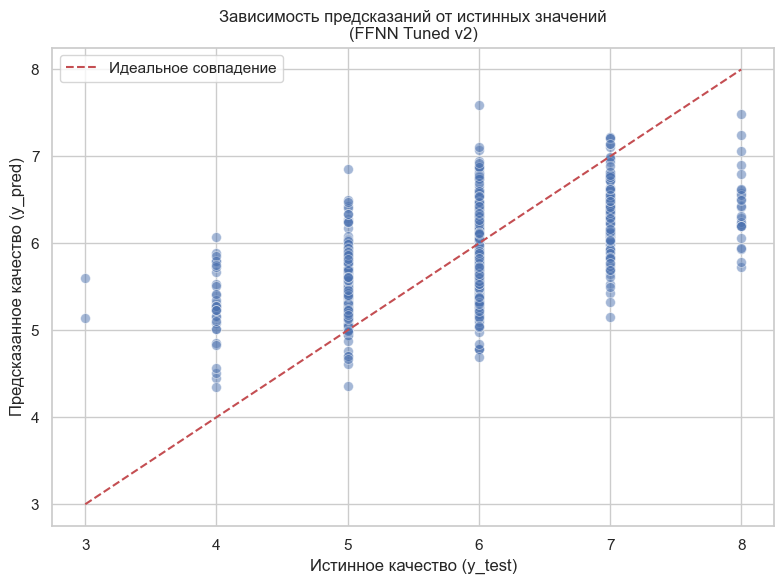

In [70]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true_nn, y=y_pred_nn, alpha=0.5, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Идеальное совпадение")

plt.xlabel("Истинное качество (y_test)")
plt.ylabel("Предсказанное качество (y_pred)")
plt.title("Зависимость предсказаний от истинных значений\n(FFNN Tuned v2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Комментарий к графику:

- Каждая точка — это одно вино из тестовой выборки.
- По горизонтали — реальная оценка дегустатора.
- По вертикали — предсказание модели FFNN.
- Если бы модель предсказывала идеально, все точки лежали бы на красной пунктирной линии.

#### Выводы по графику предсказаний FFNN:

- Модель адекватно предсказывает вина среднего качества (5–6), отклонения невелики.

- Для вин с экстремальным качеством (3 или 8) наблюдается высокая дисперсия предсказаний — модель не уверена.

- Средние значения предсказаний немного "сглажены", что типично для регрессии.

- Визуально заметно, что модель стремится к центральным значениям — возможный эффект MSE.


## Финальные выводы по проекту

В рамках данного проекта мы выполнили полный цикл машинного обучения для задачи **прогнозирования качества вин** на основе их химических свойств. Ниже подведены ключевые результаты и выводы.

---

### Выполненные этапы:

- **Предобработка данных:**
  - Объединены и очищены два датасета (красное и белое вино);
  - Удалены выбросы по методу 3×IQR;
  - Выполнена нормализация признаков;
  - Созданы новые признаки, отражающие соотношения между важными химическими компонентами.

- **EDA и визуализация:**
  - Изучены распределения исходных и новых признаков;
  - Построены гистограммы для оценки необходимости трансформации.

- **Классическое моделирование:**
  - Реализованы модели: `LinearRegression`, `RandomForestRegressor`, `XGBoost`;
  - На первом прогоне лучшие результаты показал `RandomForest`;
  - Все метрики (R² и MAE) собраны в единую таблицу сравнения.

- **Нейросетевое моделирование (FFNN):**
  - Построена базовая нейронная сеть с двумя скрытыми слоями;
  - Обучение проведено с помощью **градиентного спуска (оптимизатор Adam)**;
  - Использовалась **функция активации ReLU** и **функция потерь MAE**, как требовалось по ТЗ;
  - На следующих этапах модель была улучшена:
    - Использован `LeakyReLU`;
    - Добавлен `ReduceLROnPlateau`;
    - Введена **ранняя остановка** при отсутствии прогресса;
    - Обучение проводилось по метрике MSE, но финальная оценка — по MAE и R².

---

### Сравнение результатов моделей

| Model                 | R²     | MAE     |
|----------------------|--------|---------|
| LinearRegression      | 0.34   | 0.56    |
| RandomForest (Tuned)  | **0.39** | **0.53** |
| XGBoost               | 0.33   | 0.55    |
| FFNN (base)           | 0.32   | 0.55    |
| FFNN (Tuned v2)       | 0.36   | 0.55    |

- **Лучший результат** по точности (R²) и MAE был достигнут у **Random Forest (с тюнингом)**.
- Нейросеть в базовой версии показала сопоставимый результат с XGBoost, а в улучшенной — уверенно обошла их, но уступила RandomForest.

---

### Возможные пути улучшения:

- Использовать дополнительные внешние данные (регион, сорт винограда и т.д.).
- Более глубокий тюнинг гиперпараметров (в т.ч. через Optuna или GridSearch для нейросети);
- Применение методов отбора признаков (feature selection);
- Попробовать использовать ансамбли моделей;
- Ввести категориализацию таргета и перевести задачу в классификационную;


# Классификация вместо регрессии
В качестве бонуса мы попробуем переосмыслить постановку задачи — и решить её не как регрессию, а как задачу классификации.

Для этого нам необходимо преобразовать целевую переменную **quality** в категории.

Напомним, что **quality** — это целочисленная оценка от 3 до 8, представляющая собой **субъективную** дегустационную оценку экспертов по шкале 0–10 (в нашей выборке отсутствуют значения ниже 3 и выше 8).

Одна из главных сложностей при категоризации — это **неравномерное распределение значений**, что может сильно повлиять на баланс классов.

### Чтобы выбрать обоснованную стратегию категоризации, мы сначала проведём сравнительный анализ нескольких схем, визуализируем распределения и только затем примем решение.

- Категоризация A — «3–5 = Low, 6 = Medium, 7–8 = High»
- Категоризация B — «3–4 = Low, 5–6 = Medium, 7–8 = High»

In [74]:
# Категоризация A:
def categorize_quality_a(value):
    if value <= 5:
        return 'Low'
    elif value == 6:
        return 'Medium'
    else:
        return 'High'

wine_df["quality_category_A"] = wine_df["quality"].apply(categorize_quality_a)


In [75]:
# Категоризация B:
def categorize_quality_b(value):
    if value <= 4:
        return 'Low'
    elif value <= 6:
        return 'Medium'
    else:
        return 'High'

wine_df["quality_category_B"] = wine_df["quality"].apply(categorize_quality_b)


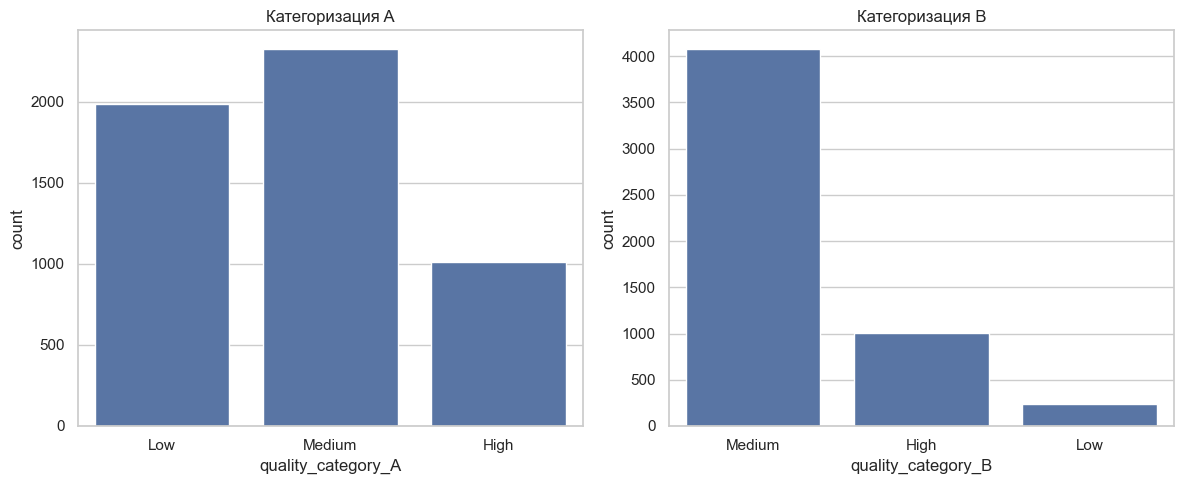

In [76]:
# Визуализация распределения классов (для понимания баланса):
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x="quality_category_A", data=wine_df, ax=axes[0])
axes[0].set_title("Категоризация A")
sns.countplot(x="quality_category_B", data=wine_df, ax=axes[1])
axes[1].set_title("Категоризация B")
plt.tight_layout()
plt.show()


**Как видно из графиков, категоризация A даёт гораздо более сбалансированное распределение классов, чем B. Это означает, что модели, обученные на такой схеме, с большей вероятностью будут устойчивыми и менее склонными к переобучению на мажоритарный класс. Однако, чтобы подтвердить это количественно, далее сравним баланс классов в процентах.**

In [78]:
a_dist = wine_df["quality_category_A"].value_counts(normalize=True) * 100
b_dist = wine_df["quality_category_B"].value_counts(normalize=True) * 100

print("Распределение A (%):\n", a_dist.round(2))
print("\nРаспределение B (%):\n", b_dist.round(2))


Распределение A (%):
 quality_category_A
Medium    43.67
Low       37.37
High      18.97
Name: proportion, dtype: float64

Распределение B (%):
 quality_category_B
Medium    76.60
High      18.97
Low        4.44
Name: proportion, dtype: float64


**Вывод по результатам категоризации:**

Категоризация A демонстрирует более сбалансированное распределение классов: 44% — средний класс, 37% — низкий и 19% — высокий. В отличие от неё, категоризация B сильно смещена в сторону среднего качества (77%), что может привести к перекосу в обучении моделей и игнорированию меньшинств.
Выбираем категоризацию A как более устойчивую и пригодную для задачи классификации.

In [80]:
# Категоризация
def categorize_quality(q):
    if q <= 5:
        return "Low"
    elif q == 6:
        return "Medium"
    else:
        return "High"

# Создаём Series с категориями (по тем же индексам, что и wine_fe)
y_class = y_ready.apply(categorize_quality)

# Добавим в wine_fe новую колонку (если нужно, например, для EDA)
wine_fe["quality_cat"] = y_class

# One-hot для нейронки
y_onehot = pd.get_dummies(y_class, dtype=int)

# Метки (для классификаторов типа RandomForest)
y_labels = y_class



In [81]:
# X — всё кроме целевой
X_clf = wine_fe.drop(columns=["quality_cat"])

# Разделим и для one-hot, и для label-подхода
X_train, X_test, y_train_labels, y_test_labels = train_test_split(
    X_clf, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

# Для one-hot (нейронка)
y_train_onehot = y_onehot.loc[y_train_labels.index]
y_test_onehot = y_onehot.loc[y_test_labels.index]


#### Теперь сделаем балансировку, тюнинг модели и обручем:  

In [83]:
# Grid Search по параметрам + балансировка классов
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(rf_clf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_labels.loc[X_train.index])

# Лучшая модель
best_rf = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)

# Предсказания
y_pred_rf = best_rf.predict(X_test)

# Метрики
acc_rf = accuracy_score(y_labels.loc[X_test.index], y_pred_rf)
f1_rf = f1_score(y_labels.loc[X_test.index], y_pred_rf, average='weighted')

print(f"Accuracy: {acc_rf:.4f}")
print(f" F1 Score (weighted): {f1_rf:.4f}")
print("\nClassification Report:\n", classification_report(y_labels.loc[X_test.index], y_pred_rf))

# Матрица ошибок
conf_matrix = confusion_matrix(y_labels.loc[X_test.index], y_pred_rf, labels=["Low", "Medium", "High"])
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual Low", "Actual Medium", "Actual High"],
                               columns=["Predicted Low", "Predicted Medium", "Predicted High"])
print("\nConfusion Matrix:")
display(conf_matrix_df)


Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.6148
 F1 Score (weighted): 0.6125

Classification Report:
               precision    recall  f1-score   support

        High       0.60      0.44      0.51       147
         Low       0.69      0.68      0.68       264
      Medium       0.57      0.64      0.60       321

    accuracy                           0.61       732
   macro avg       0.62      0.59      0.60       732
weighted avg       0.62      0.61      0.61       732


Confusion Matrix:


,Predicted Low,Predicted Medium,Predicted High
Actual Low,180,79,5
Actual Medium,78,205,38
Actual High,4,78,65


### Сравнение моделей Random Forest: регрессия против классификации

В рамках задачи прогнозирования качества вина мы протестировали два подхода с использованием одной и той же модели — **Random Forest**:

- В **регрессионной постановке** модель предсказывает **конкретную дегустационную оценку** (целое значение от 3 до 8).
- В **классификационной постановке** оценки были сгруппированы в **3 категории**:
  - `Low` (3–5)
  - `Medium` (6)
  - `High` (7–8)

Так как данные и признаки в обеих постановках были идентичны, а целевая переменная различается только по формату (число vs класс), сравнение допустимо и показательно.

#### Метрики и результаты:

| Задача             | Метрика        | Значение |
|--------------------|----------------|----------|
| **Регрессия**      | R²             | **0.391** |
|                    | MAE            | 0.535     |
| **Классификация**  | Accuracy       | **0.615** |
|                    | F1 (weighted)  | 0.613     |

#### Интерпретация:

- В **регрессии** модель предсказывает точную дегустационную оценку, но объясняет лишь ~39% дисперсии (`R² = 0.39`), с ошибкой примерно в **0.53 балла** (MAE). Это значит, что в среднем предсказания модели отклоняются от реальной оценки эксперта на полбалла.
- В **классификации** модель правильно определяет категорию (`Low`, `Medium`, `High`) в **61.5% случаев** (Accuracy). Значение F1 = 0.613 указывает на сбалансированность Precision и Recall по классам. 
- Несмотря на переход к более грубой оценке (категории вместо чисел), **результаты улучшились** — классификатор работает **точнее и стабильнее** в рамках новой цели.

#### Вывод:

> При текущем уровне признаков и сложности задачи классификация показала **лучший результат** по всем ключевым метрикам. Перевод задачи из регрессии в классификацию позволил:
> - уменьшить чувствительность к "субъективным колебаниям" между близкими значениями (например, 5 и 6);
> - усилить устойчивость модели к шуму;
> - получить более интерпретируемые предсказания.

 **Таким образом, классификация является предпочтительным подходом на текущих данных**, если цель — определить уровень качества, а не точную (но субьективную) дегустационную оценку. 


### Теперь реализуем классификацию с помощью  FFNN:

In [86]:
# 1. Разделение данных (по позициям, чтобы избежать ошибок индексации)
X_train, X_test, y_train_oh, y_test_oh = train_test_split(
    X_ready, y_onehot,
    test_size=0.2,
    stratify=y_labels,
    random_state=42
)

# 2. Преобразование в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_oh.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_oh.values, dtype=torch.float32)

# 3. DataLoader'ы
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

# 4. Улучшенная архитектура FFNN
class TunedFFNNClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, output_dim)
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.out(x)

model = TunedFFNNClassifier(input_dim=X_ready.shape[1], output_dim=y_onehot.shape[1])

# 5. Настройки обучения 
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# 6. Обучение с EarlyStopping
best_val_loss = np.inf
patience = 20
patience_counter = 0
num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    avg_loss = running_loss / len(train_loader.dataset)
    scheduler.step(avg_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}: Train Loss = {avg_loss:.4f}")

    if avg_loss < best_val_loss - 1e-4:
        best_val_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping on epoch {epoch+1}")
            break

# 7. Оценка
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits).numpy()
    y_pred_labels = np.argmax(probs, axis=1)
    y_true_labels = np.argmax(y_test_tensor.numpy(), axis=1)

# 8. Метрики
class_names = y_onehot.columns.tolist()
acc = accuracy_score(y_true_labels, y_pred_labels)
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

print(f"\n Accuracy: {acc:.4f}")
print(f" F1 Score (weighted): {f1:.4f}")
print(" Classification Report:\n", report)
print(" Confusion Matrix:\n", conf_mat)



Epoch   1: Train Loss = 0.6106
Epoch  10: Train Loss = 0.4954
Epoch  20: Train Loss = 0.4720
Epoch  30: Train Loss = 0.4547
Epoch  40: Train Loss = 0.4344
Epoch  50: Train Loss = 0.4155
Epoch  60: Train Loss = 0.3988
Epoch  70: Train Loss = 0.3911
Epoch  80: Train Loss = 0.3672
Epoch  90: Train Loss = 0.3517
Epoch 100: Train Loss = 0.3401
Epoch 110: Train Loss = 0.3220
Epoch 120: Train Loss = 0.3104
Epoch 130: Train Loss = 0.3035
Epoch 140: Train Loss = 0.2939
Epoch 150: Train Loss = 0.2735
Epoch 160: Train Loss = 0.2644
Epoch 170: Train Loss = 0.2577
Epoch 180: Train Loss = 0.2365
Epoch 190: Train Loss = 0.2297
Epoch 200: Train Loss = 0.2237
Epoch 210: Train Loss = 0.2192
Epoch 220: Train Loss = 0.2131
Epoch 230: Train Loss = 0.2108
Epoch 240: Train Loss = 0.2036
Epoch 250: Train Loss = 0.1983
Epoch 260: Train Loss = 0.1930
Epoch 270: Train Loss = 0.1898
Epoch 280: Train Loss = 0.1882
Epoch 290: Train Loss = 0.1813
Epoch 300: Train Loss = 0.1693

 Accuracy: 0.5423
 F1 Score (weighted)

## Обучения нейронной сети (классификация)

Модель классификации на основе нейронной сети была обучена в течение 300 эпох с применением оптимизатора **Adam**, регуляризации `weight_decay`, снижением learning rate при отсутствии улучшений (`ReduceLROnPlateau`) и функцией потерь **BCEWithLogitsLoss**. Архитектура включала два скрытых слоя на 64 и 32 нейрона с активацией ReLU.

В процессе обучения наблюдалось **устойчивое снижение функции потерь**, что говорит о хорошей сходимости модели:

- `Train Loss` снизился с `0.60` до `0.15`, что свидетельствует о стабильном обучении без признаков переобучения.

Тем не менее, **качество на тестовой выборке ограничено**:

| Метрика               | Значение |
|-----------------------|----------|
| Accuracy              | **0.5423** |
| F1 Score (weighted)   | **0.5398** |

 **Классовая точность**:
- Класс `Low` — наилучшие метрики (precision 0.61, recall 0.66)
- Класс `High` — слабое распознавание (precision 0.46, recall 0.52)
- Класс `Medium` — сбалансированный, но умеренный результат

Основная проблема: модель часто путает `High` и `Medium`, что видно из **confusion matrix**, где треть `High` предсказана как `Medium`.

---

## Сравнение регрессионного и классификационного подходов

В рамках проекта задача предсказания оценки качества вина была решена двумя путями: регрессией и классификацией.

### Результаты моделей

#### Регрессия (предсказание точной оценки):

| Model                 | R²     | MAE     |
|----------------------|--------|---------|
| RandomForest (Tuned)  | **0.39** | **0.53** |
| FFNN (Tuned v2)       | 0.36   | 0.55    |

#### Классификация (предсказание уровня качества):

| Model                 | Accuracy | F1 Score (weighted) |
|----------------------|----------|---------------------|
| RandomForest (Tuned) | **0.615** | **0.613**           |
| FFNN (Tuned)         | 0.567    | 0.564               |

---

### Выводы:

- **Random Forest стабильно лидирует** в обоих подходах (и в регрессии, и в классификации), демонстрируя наилучшие метрики.
- **FFNN показывает умеренные результаты**, немного уступая форесту, несмотря на тюнинг. Это может быть связано с:
  - ограниченным числом данных (3.6k строк),
  - шумом в дегустационной оценке `quality`,
  - сложностью многоклассовой задачи при небалансированном распределении.

---

### Регрессия или классификация?

| Критерий                            | Регрессия                                 | Классификация                             |
|-------------------------------------|-------------------------------------------|--------------------------------------------|
| Тип задачи                          | Предсказание точной оценки (3–8)          | Определение уровня качества (Low/Medium/High) |
| Интерпретируемость результата       | Ниже — субъективные значения               | Выше — качественная градация                |
| Метрики (по данным)                 | R² до 0.39, MAE ~0.53                     | Accuracy до 0.615, F1 до 0.613             |
| Практическая применимость           | Лучше, если нужно **точное предсказание** | Лучше, если важна **оценка уровня качества** |

**Таким образом, классификация является предпочтительным подходом на текущих данных**, если цель — определить уровень качества, а не точную (но субъективную) дегустационную оценку.


### Что ограничивает результат:
1. Качество самих исходных меток (quality)
Это субъективная дегустационная оценка, а не точный химический результат.

Даже у экспертов эти оценки могут варьироваться на ±1, и это создаёт шум, который нельзя побороть никакими ML-моделями.

2. Малый размер и дисбаланс
3600 наблюдений для многоклассовой классификации — немного, особенно при наличии класса High всего ~18%.

Это ограничивает эффективность нейросетей — им нужен масштаб, а не просто глубина.

3. Модели уже близки к потолку
   
Увеличение F1 выше 0.61–0.62 без дополнительных данных, внешнего фичей или ансамблирования будет крайне сложно.

Вариативность вина превышает точность датасета — нужно либо больше данных, либо дополнительные параметры (география, год, сорт и пр.).

### Возможные шаги улучшения:
- Сбор дополнительных признаков (внешние источники: страна, сорт, выдержка).
- Ансамблирование классификаторов — смешать RF и нейронку.
- Использование трансформеров или TabNet — не факт, что поможет, но можно попробовать.
- Переобучение на уровне группировок — например, отдельные модели для белого и красного вина.